In [1]:
%pylab inline
import os
from collections import namedtuple
import pyro
import pyro.optim as optim
# from pyro.infer import SVI, TraceGraph_ELBO
from pyro.infer import SVI, Trace_ELBO, TraceEnum_ELBO, config_enumerate
import pyro.distributions as dist
import pyro.poutine as poutine
import pyro.contrib.examples.multi_mnist as multi_mnist
import torch
import torch.nn as nn
from torch.nn.functional import relu, tanh, sigmoid, softplus, grid_sample, affine_grid
import numpy as np

smoke_test = ('CI' in os.environ)
# assert pyro.__version__.startswith('1.8.0')

Populating the interactive namespace from numpy and matplotlib


In [2]:
torch.cuda.is_available()

True

In [3]:
# torch.set_default_tensor_type('torch.cuda.FloatTensor')

In [4]:
device = torch.device('cuda:0')

In [5]:
X_np = torch.load("X").numpy()

dsb = torch.from_numpy(X_np)
def show_images(imgs, figsize=(8, 2), dpi=300):
    figure(figsize=figsize, dpi=dpi)
    for i, img in enumerate(imgs):
        subplot(1, len(imgs), i + 1)
        axis('off')
        imshow(img.data.numpy(), cmap='gray')
show_images(dsb[9:14])




FileNotFoundError: [Errno 2] No such file or directory: 'X'

In [6]:
y_pres = torch.load("y_pres")

In [7]:
y_pres.shape

torch.Size([2013, 8, 8])

In [8]:
N, img_height, img_width = X_np.shape
obj_height, obj_width = 100, 100

bounding_box_height_min, bounding_box_width_min = 30, 30
bounding_box_height_max, bounding_box_width_max = 70, 70

bounding_box_height_scale_min, bounding_box_width_scale_min = \
    img_height / bounding_box_height_max, img_width / bounding_box_width_max
bounding_box_height_scale_max, bounding_box_width_scale_max = \
    img_height / bounding_box_height_min, img_width / bounding_box_width_min

bouding_box_scale_min = bounding_box_width_scale_min
bouding_box_scale_max = bounding_box_width_scale_max

z_what_latent_size = 100

# b_min, b_max = 3, 27
# a_h, a_w = 30, 30
# object_counts=50
# lstm_input_size = 256*256+z_what_latent_size+4
# print(lstm_input_size)

In [9]:
bouding_box_scale_min

3.657142857142857

In [10]:
bouding_box_scale_max

8.533333333333333

# Model

## check the prior

In [11]:
from sympy.solvers import solve
from sympy import Symbol, var
from sympy.solvers.diophantine import diophantine
from sympy.solvers.diophantine.diophantine import diop_solve
from sympy.solvers.diophantine.diophantine import diop_ternary_quadratic

In [12]:
def solve_padding_dilation(h_in, h_out, kernel_size=3, stride=1):
    H_in = Symbol("H_in", integer=True, positive=True)
    H_out = Symbol("H_out", integer=True, positive=True)
    padding = var("padding", integer=True, positive=True)
    dilation = var("dilation", integer=True, positive=True)
    # dilation=1
    # kernel_size = Symbol("kernel_size", integer=True)
    # kernel_size = 3
    # stride = Symbol("stride", integer=True)
    # stride = 1
    # m = Symbol("m", integer=True)

    H_in

    equation = (H_in + 2 * padding - dilation * (kernel_size - 1) - 1) / stride  + 1 - H_out
    # equation.subs({H_in:32, H_out:40, padding:0})
    
    for i in range(100):
        

        solution = diophantine(equation.subs({H_in:h_in, H_out:h_out, padding:i}))
        
        # print(solution)
        
        if len(solution) == 0:
            continue

        dilation_val = list(solution)[0][0]
        
        print(solution, dilation_val)
        if dilation_val > 0:
            padding_val = i
            break
    return padding_val, dilation_val

In [13]:
# Create the neural network. This takes a latent code, z_what, to pixel intensities.
class Decoder(nn.Module):
    def __init__(self, use_cuda=True, *args, **kargs):
        super().__init__(*args, **kargs)
        
        self.l1 = nn.Linear(z_what_latent_size, 1024*1*1)
        self.u1 = nn.Unflatten(1, (1024, 1, 1))
        
        # 1x1 -> 2x2
        self.t1  = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.c1a = nn.Conv2d(512, 256, 3, padding="same")
        
        
        # 2x2 -> 4x4
        self.t2  = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.c2a = nn.Conv2d(128, 64, 3, padding="same")
        
        # 4x4 -> 8x8
        self.t3  = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.c3a = nn.Conv2d(32, 16, 3, padding="same")
        
        # 8x8 -> 16x16
        self.t4  = nn.ConvTranspose2d(16, 8, 2, stride=2)
        self.c4a = nn.Conv2d(8, 4, 3, padding="same")

        
        # 16x16 -> 32x32
        self.t5  = nn.ConvTranspose2d(4, 2, 2, stride=2)
        self.c5a = nn.Conv2d(2, 1, 3, padding="same")

        obj_dim = obj_height
        padding, dilation = solve_padding_dilation(32, obj_dim, kernel_size=3, stride=1)
        
                
        self.cn = nn.Conv2d(1, 1, 3, stride=1, padding=padding, dilation=dilation)
        self.fn = nn.Flatten()
        
        if use_cuda:
            self.cuda(device=device)

    def forward(self, z_what):
        # h = relu(self.l1(z_what))
        # h = self.l1(z_what)
        # h = relu(h)
        # h = self.l2(h)
        # h = sigmoid(h)
        
        h = self.l1(z_what)
        h = tanh(h)
        h = self.u1(h)
        
        h = self.t1(h)
        h = tanh(h)
        h = self.c1a(h)
        h = tanh(h)

        
        h = self.t2(h)
        h = tanh(h)
        h = self.c2a(h)
        h = tanh(h)
        
        h = self.t3(h)
        h = tanh(h)
        h = self.c3a(h)
        h = tanh(h)
                 
        h = self.t4(h)
        h = tanh(h)
        h = self.c4a(h)
        h = tanh(h)
                 
        h = self.t5(h)
        h = tanh(h)
        h = self.c5a(h)
        h = tanh(h)

        
        h = self.cn(h)
        h = self.fn(h)
        
        
        h = sigmoid(h)
        
        # return sigmoid(self.l2(h))
        return h

In [14]:
def expand_z_where(z_where):
    # Takes 3-dimensional vectors, and massages them into 2x3 matrices with elements like so:
    # [s,x,y] -> [[s,0,x],
    #             [0,s,y]]
    n = z_where.size(0)
    expansion_indices = torch.cuda.LongTensor([1, 0, 2, 0, 1, 3], device=device)
    out = torch.cat((torch.zeros([1, 1]).expand(n, 1).cuda(device=device), z_where), 1)
    return torch.index_select(out, 1, expansion_indices).view(n, 2, 3)

def object_to_image(z_where, obj):
    n = obj.size(0)
    theta = expand_z_where(z_where)
    grid = affine_grid(theta, torch.Size((n, 1,img_height, img_width)))
    out = grid_sample(obj.view(n, 1, obj_height, obj_width), grid)
    return out.view(n, img_height, img_width)

# def object_to_image_in_compartment(i, j, z_where, obj):
#     n = obj.size(0)
#     theta = expand_z_where(z_where)
#     grid = affine_grid(theta, torch.Size((n, 1,img_height, img_width)))
#     out = grid_sample(obj.view(n, 1, obj_height, obj_width), grid)
#     return out.view(n, img_height, img_width)

def z_where_inv(z_where):
    # Take a batch of z_where vectors, and compute their "inverse".
    # That is, for each row compute:
    # [s,x,y] -> [1/s,-x/s,-y/s]
    # These are the parameters required to perform the inverse of the
    # spatial transform performed in the generative model.
    n = z_where.size(0)
    out = torch.cat((torch.ones([1, 1], device=device).type_as(z_where).expand(n, 1), -z_where[:, 1:]), 1)
    out = out / z_where[:, 0:1]
    return out

def image_to_object(z_where, image):
    n = image.size(0)
    theta_inv = expand_z_where(z_where_inv(z_where))
    grid = affine_grid(theta_inv, torch.Size((n, 1, obj_height, obj_width)))
    out = grid_sample(image.view(n, 1, img_height, img_width), grid)
    return out.view(n, -1)

def image_to_selected(z_where, image):
    n = image.size(0)
    theta_inv = expand_z_where(z_where_inv(z_where))
    grid = affine_grid(theta_inv, torch.Size((n, 1, obj_height, obj_width)))
    out = grid_sample(image.view(n, 1, img_height, img_width), grid)
    
    theta = expand_z_where(z_where)
    grid = affine_grid(theta, torch.Size((n ,1, img_height, img_width)))
    out = grid_sample(out.view(n, 1, obj_height, obj_width), grid)
    
    # return out.view(n, -1)
    return out

In [15]:

z_where_prior_loc = torch.tensor([5., 0., 0.])
z_where_prior_scale = torch.tensor([10, 1, 1])
z_what_prior_loc = torch.zeros(z_what_latent_size)
z_what_prior_scale = torch.ones(z_what_latent_size)

decode = Decoder()

def prior_step_sketch(i, j, background_left):
    # Sample object pose. This is a 3-dimensional vector representing x,y position and size.
    z_where = pyro.sample('z_where_{}_{}'.format(i, j),
                          dist.Normal(z_where_prior_loc.expand(1, -1),
                                      z_where_prior_scale.expand(1, -1))
                              .to_event(1)
                         ).cuda(device=device)
    
    z_where_resize = sigmoid(z_where[:, 0:1])*(bouding_box_scale_max - bouding_box_scale_min)+bouding_box_scale_min
    z_where_rescaled = torch.cat(
        [
            z_where_resize, 
            z_where_resize * tanh(z_where[:,1:3]) * 0.5 * 0.25
        ], 
        1
    )
    z_where_in_compartment = z_where_rescaled +  z_where_rescaled[:, 0:1] * torch.tensor([0, -(j-4+0.5)/4., -(i-4+0.5)/4.]).expand(1, -1).cuda(device=device)
    
    # Sample object code. This is a 50-dimensional vector.
    z_what = pyro.sample('z_what_{}_{}'.format(i, j),
                         dist.Normal(z_what_prior_loc.expand(1, -1),
                                     z_what_prior_scale.expand(1, -1))
                             .to_event(1)
                        ).cuda(device=device)

    # Map code to pixel space using the neural network.
    y_attend = decode(z_what)

    object_visible = image_to_object(z_where_in_compartment, background_left)
    object_score = torch.clamp(object_to_image(z_where_in_compartment, object_visible), 0., 1.)
    background_left = background_left * (1. - object_score)

    
    # Position/scale object within larger image.
    # y = object_to_image(z_where.cuda(device=device), y_attend)
    y = object_to_image(z_where_in_compartment, y_attend)

    return y, background_left

{(0,)} 0
{(1,)} 1


In [16]:
# # pyro.set_rng_seed(0)
# samples = [prior_step_sketch(i, i)[0].cpu() for i in range(8)]
# show_images(samples)

In [17]:
background_left_last = background_left = torch.ones(1, img_height, img_width).cuda(device=device)

samples = []
for i in range(8):
    y, backgroud_left = prior_step_sketch(i, i, background_left)
    y = y * background_left_last
    background_left_last = backgroud_left
    samples.append(y)

/home/lachlan/miniconda3/envs/rbmvae/lib/python3.7/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/lachlan/miniconda3/envs/rbmvae/lib/python3.7/site-packages/torch/nn/functional.py:1794: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/lachlan/miniconda3/envs/rbmvae/lib/python3.7/site-packages/torch/nn/functional.py:4044: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/home/lachlan/miniconda3/envs/rbmvae/lib/python3.7/site-packages/torch/nn/functional.py:3982: UserWarning: Default grid_sample

In [18]:
samples_merged  = samples[0]

for i in range(1, 8):
    samples_merged += samples[i]
    

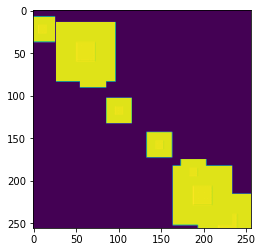

In [19]:
plt.imshow(samples[0].cpu().detach().numpy()[0] )

In [20]:
samples_merged.shape

torch.Size([1, 256, 256])

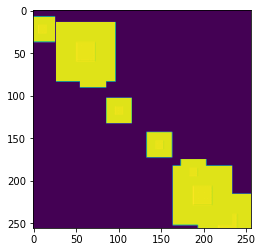

In [21]:
plt.imshow(samples_merged[0].cpu().detach().numpy())

In [22]:
pyro.set_rng_seed(0)
def geom(num_trials=0):
    p = torch.tensor([0.05]).cuda(device=device)
    x = pyro.sample('x{}'.format(num_trials), dist.Bernoulli(p))
    if x[0] == 1:
        return num_trials
    else:
        return geom(num_trials + 1)

# Generate some samples.
for _ in range(5):
    print('sampled {}'.format(geom()))

sampled 21
sampled 45
sampled 0
sampled 48
sampled 3


In [23]:
def geom_prior(x, background_left, step=0):
    p = torch.tensor([0.1]).cuda(device=device)
    i = pyro.sample('i{}'.format(step), dist.Bernoulli(p))
    
    background_left_last = background_left
    
    if i[0] == 1:
        return x, background_left
    else:
        x_, backgroud_left =  prior_step_sketch(3, 3, background_left)
        x = x + x_ * background_left_last
        return geom_prior(x, backgroud_left, step + 1)[0], backgroud_left

In [24]:
pyro.set_rng_seed(4)
x_empty = torch.zeros(1, img_height, img_width).cuda(device=device)
background_left_last = background_left = torch.ones(1, img_height, img_width).cuda(device=device)
# samples = [geom_prior(x_empty)[0].cpu() for _ in range(8)]
samples = []
for i in range(8):
    x, backgroud_left = geom_prior(x_empty, background_left)
    samples.append(x[0].cpu())

In [25]:
samples[0]

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], grad_fn=<CopyBackwards>)

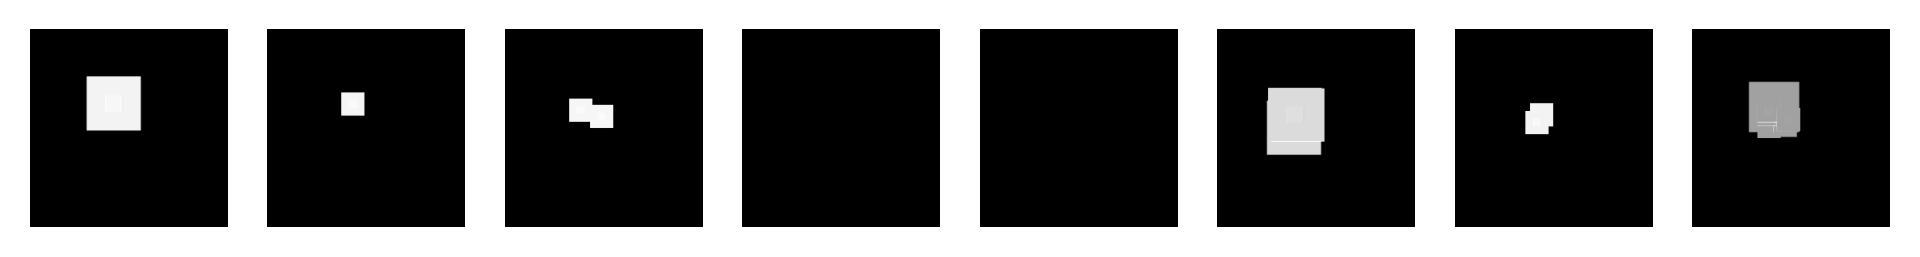

In [26]:
show_images(samples)

## SVI model

In [27]:
z_where_prior_loc = torch.tensor([5., 0., 0.])
z_where_prior_scale = torch.tensor([2., 1., 1.])
z_what_prior_loc = torch.zeros(z_what_latent_size)
z_what_prior_scale = torch.ones(z_what_latent_size)

decode=Decoder(use_cuda=True)

{(0,)} 0
{(1,)} 1


In [28]:
# def z_pres_prior(n, c, k):
#     pass

In [29]:
# s = 0.9
# combinations = lambda n, m: math.factorial(n)/(math.factorial(m) * math.factorial(n-m))
# [s * (1-s) ** k / ((1 - (1 - s)**(65) * combinations(64, k))) for k in range(64)]

In [30]:
s = 0.5
z_pres_counts_p_ = torch.tensor([s * ((1-s)**k) / (1-(1-s)**(64+1)) for k in range(65)]).view(1, 65) #+ 1.4013e-45
print(z_pres_counts_p_)

tensor([[5.0000e-01, 2.5000e-01, 1.2500e-01, 6.2500e-02, 3.1250e-02, 1.5625e-02,
         7.8125e-03, 3.9062e-03, 1.9531e-03, 9.7656e-04, 4.8828e-04, 2.4414e-04,
         1.2207e-04, 6.1035e-05, 3.0518e-05, 1.5259e-05, 7.6294e-06, 3.8147e-06,
         1.9073e-06, 9.5367e-07, 4.7684e-07, 2.3842e-07, 1.1921e-07, 5.9605e-08,
         2.9802e-08, 1.4901e-08, 7.4506e-09, 3.7253e-09, 1.8626e-09, 9.3132e-10,
         4.6566e-10, 2.3283e-10, 1.1642e-10, 5.8208e-11, 2.9104e-11, 1.4552e-11,
         7.2760e-12, 3.6380e-12, 1.8190e-12, 9.0949e-13, 4.5475e-13, 2.2737e-13,
         1.1369e-13, 5.6843e-14, 2.8422e-14, 1.4211e-14, 7.1054e-15, 3.5527e-15,
         1.7764e-15, 8.8818e-16, 4.4409e-16, 2.2204e-16, 1.1102e-16, 5.5511e-17,
         2.7756e-17, 1.3878e-17, 6.9389e-18, 3.4694e-18, 1.7347e-18, 8.6736e-19,
         4.3368e-19, 2.1684e-19, 1.0842e-19, 5.4210e-20, 2.7105e-20]])


In [31]:
# def prior_step(n, t, prev_x, prev_z_pres):
def prior_step(n, i, j, background_left, prev_x, prev_z_pres, z_pres_p_unmasked):

    # Sample variable indicating whether to add this object to the output.

    # We multiply the success probability of 0.5 by the value sampled for this
    # choice in the previous step. By doing so we add objects to the output until
    # the first 0 is sampled, after which we add no further objects.
    
    k = i*8+j+1
    # z_pres_counts_p = z_pres_counts_p_.expand(n, 65)
    # z_pres_p = torch.zeros([n, 65])
    counts = torch.arange(0, 65).view(1, 65).expand(n, -1)
    prev_z_pres_counts = prev_z_pres.expand(n, 65)
    z_pres_p = z_pres_p_unmasked * torch.clamp((counts - prev_z_pres_counts) * torch.gt(counts, prev_z_pres_counts) / (64 - (k-1)), min=0, max=1)
    
    # print(z_pres_p.sum(1, keepdim=True))
    
    
    # print("k: ", k)
    # print("denominator: ", (counts - prev_z_pres_counts) * torch.gt(counts, prev_z_pres_counts) / (64 - (k-1)) )
    # print("counts: ", counts)
    # print("prev_z_pres_counts: ", prev_z_pres_counts)
    # print("z_pres_p.shape: ", z_pres_p.shape)
    # print("z_pres_p: ", z_pres_p.sum(1))
    
    z_pres = pyro.sample('z_pres_{}_{}'.format(i, j),
                         dist.Bernoulli(z_pres_p.sum(1, keepdim=True).expand(n, -1))
                             .to_event(1)).cuda(device=device)

    z_where = pyro.sample('z_where_{}_{}'.format(i, j),
                          dist.Normal(z_where_prior_loc.expand(n, -1),
                                      z_where_prior_scale.expand(n, -1))
                              .mask(z_pres.cpu())
                              .to_event(1)).cuda(device=device)

    z_what = pyro.sample('z_what_{}_{}'.format(i, j),
                         dist.Normal(z_what_prior_loc.expand(n, -1),
                                     z_what_prior_scale.expand(n, -1))
                             .mask(z_pres.cpu())
                             .to_event(1)).cuda(device=device)
    
    z_where_resize = sigmoid(z_where[:, 0:1])*(bouding_box_scale_max - bouding_box_scale_min)+bouding_box_scale_min
    z_where_rescaled = torch.cat(
        [
            z_where_resize, 
            z_where_resize * tanh(z_where[:,1:3]) * 0.5 * 0.25
        ], 
        1
    )
    z_where_in_compartment = z_where_rescaled +  z_where_rescaled[:, 0:1] * torch.tensor([0, -(j-4+0.5)/4., -(i-4+0.5)/4.]).expand(n, -1).cuda(device=device)


    y_attend = decode(z_what)
    y = object_to_image(z_where_in_compartment, y_attend)
    
    background_left_last = background_left
    object_visible = image_to_object(z_where_in_compartment, background_left)
    object_score = torch.clamp(object_to_image(z_where_in_compartment, object_visible), 0., 1.)
    background_left = background_left * (1. - object_score * z_pres.view(-1, 1, 1))


    # Combine the image generated at this step with the image so far.
    x = prev_x + y * background_left_last * z_pres.view(-1, 1, 1)


    return x, background_left, z_where_in_compartment, prev_z_pres + z_pres.cpu(), z_pres_p

In [32]:
def prior(n):
    x = torch.zeros(n, img_height, img_width).cuda(device=device)
    z_wheres = []
    z_preses = []
    
    z_pres = torch.zeros(n, 1)
    z_pres_p = z_pres_counts_p_.expand(n, -1)
    background_left_last = background_left = torch.ones(n, img_height, img_width).cuda(device=device)
    for i in range(8):
        for j in range(8):
            
            x, background_left, z_where, z_pres, z_pres_p = prior_step(n, i, j, background_left, x, z_pres, z_pres_p)
            z_wheres.append(z_where)
            z_preses.append(z_pres)
    
    return x, z_wheres, z_preses

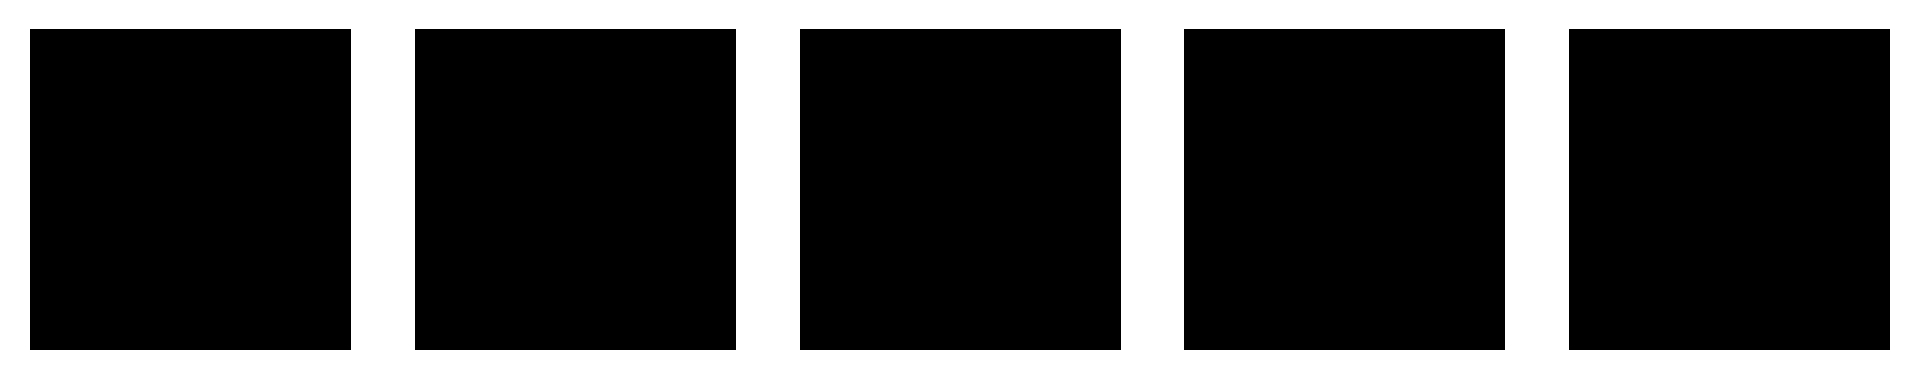

In [33]:
# pyro.set_rng_seed(0)
show_images(prior(5)[0].cpu())

In [34]:
def model(data, y_pres):
    # Register network for optimization.
    pyro.module("decode", decode)
    with pyro.plate('data', data.size(0)) as indices:
        batch = data[indices]
        x, z_wheres, z_preses = prior(batch.size(0))
        x = x.view(-1, img_height * img_width).cpu()
        # x = prior(batch.size(0))
        sd = (0.3 * torch.ones(1)).expand_as(x)
        pyro.sample('obs', dist.Normal(x, sd).to_event(1),
                    obs=batch.cpu())
        
        comp_v = compartment(batch.view(-1, 1, img_height, img_width).cuda(device=device))
        for i in range(8):
            for j in range(8):
                y_pres_p, _, _ = predict_spair(comp_v[:, :, i, j], None)
                
                with pyro.poutine.scale(scale=46):
                    pyro.sample(f"y_pres_{i}_{j}", dist.Bernoulli(y_pres_p.cpu()).to_event(1), obs=y_pres[indices,i,j].view(-1, 1).cpu())

# Guide

In [35]:
solve_padding_dilation(obj_width, 128)

{(0,)} 0
{(1,)} 1


(15, 1)

In [36]:
# Takes pixel intensities of the attention window to parameters (mean,
# standard deviation) of the distribution over the latent code,
# z_what.
class Encoder(nn.Module):
    def __init__(self, use_cuda=True, *args, **kargs):
        super().__init__(*args, **kargs)
        
        # self.l1 = nn.Linear(obj_height*obj_width, 200)
        # self.l2 = nn.Linear(200, z_what_latent_size*2)
        
        # self.l1 = nn.Linear(obj_height*obj_width, 32*32)
        self.u1 = nn.Unflatten(1, (1, obj_height, obj_width))
        
        padding, dilation = solve_padding_dilation(obj_width, 128, kernel_size=3, stride=1)
        self.c0 = nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=padding, dilation=dilation)
        
        # 128x128 -> 64x64
        self.c1 = nn.Conv2d(1, 2, 3, 1, padding="same")
        self.p1 = nn.MaxPool2d(2, stride=2)
        self.c1a = nn.Conv2d(2, 4, 3, 1, padding="same")
        
        
        # 64x64 -> 32x32
        self.c2 = nn.Conv2d(4, 8, 3, 1, padding="same")
        self.p2 = nn.MaxPool2d(2, stride=2)
        self.c2a = nn.Conv2d(8, 16, 3, 1, padding="same")
        
        
        # 32x32 -> 16x16
        self.c3 = nn.Conv2d(16, 32, 3, 1, padding="same")
        self.p3 = nn.MaxPool2d(2, stride=2)
        self.c3a = nn.Conv2d(32, 64, 3, 1, padding="same")

        
        # 16x16 -> 8x8
        self.c4 = nn.Conv2d(64, 128, 3, 1, padding="same")
        self.p4 = nn.MaxPool2d(2, stride=2)
        self.c4a = nn.Conv2d(128, 256, 3, 1, padding="same")

        
        
        # 8x8 -> 4x4
        self.c5 = nn.Conv2d(256, 512, 3, 1, padding="same")
        self.p5 = nn.MaxPool2d(2, stride=2)
        self.c5a = nn.Conv2d(512, 1024, 3, 1, padding="same")
        
        
        # 4x4 -> 2x2
        self.c6 = nn.Conv2d(1024, 512, 3, 1, padding="same")
        self.p6 = nn.MaxPool2d(2, stride=2)
        self.c6a = nn.Conv2d(512, 1024, 3, 1, padding="same")
        
        # 2x2 -> 1x1
        self.c7 = nn.Conv2d(1024, 512, 3, 1, padding="same")
        self.p7 = nn.MaxPool2d(2, stride=2)
        self.c7a = nn.Conv2d(512, 1024, 3, 1, padding="same")
        
        self.f2 = nn.Flatten()
        self.l2 = nn.Linear(1024*1*1, z_what_latent_size*2)
        
        
        if use_cuda:
            self.cuda(device=device)

    def forward(self, data):
        # h = relu(self.l1(data))
        # h = self.l1(data)
        # h = relu(h)
        # a = self.l2(h)
        
        # h = self.l1(data)
        # h = tanh(h)
        h = self.u1(data)
        h = self.c0(h)
        h = tanh(h)
        
        h = self.c1(h)
        h = tanh(h)
        h = self.p1(h)
        h = self.c1a(h)
        h = tanh(h)

        
        h = self.c2(h)
        h = tanh(h)
        h = self.p2(h)
        h = self.c2a(h)
        h = tanh(h)
        
        h = self.c3(h)
        h = tanh(h)
        h = self.p3(h)
        h = self.c3a(h)
        h = tanh(h)
        
        h = self.c4(h)
        h = tanh(h)
        h = self.p4(h)
        h = self.c4a(h)
        h = tanh(h)
        
        h = self.c5(h)
        h = tanh(h)
        h = self.p5(h)
        h = self.c5a(h)
        h = tanh(h)
        
        h = self.c6(h)
        h = tanh(h)
        h = self.p6(h)
        h = self.c6a(h)
        h = tanh(h)
        
        h = self.c7(h)
        h = tanh(h)
        h = self.p7(h)
        h = self.c7a(h)
        h = tanh(h)

        
        h = self.f2(h)
        a = self.l2(h)
        
        z_loc = a[:, 0:z_what_latent_size]
        z_scale = softplus(a[:, z_what_latent_size:])
        return z_loc, z_scale
        
      

In [37]:
## 一个 compartment 一个细胞就不需要 LSTM
class Compartment(nn.Module):
    def __init__(self ,use_cuda=True, *args, **kargs):
        super().__init__(*args, **kargs)
        
        # 256x256 -> 128x128
        self.c1 = nn.Conv2d(1, 8, 3, 1, padding="same")
        self.p1 = nn.MaxPool2d(2, stride=2)
        
        # 128x128 -> 64x64
        self.c2 = nn.Conv2d(8, 32, 3, 1, padding="same")
        self.p2 = nn.MaxPool2d(2, stride=2)
        
        # 64x64 -> 32x32
        self.c3 = nn.Conv2d(32, 64, 3, 1, padding="same")
        self.p3 = nn.MaxPool2d(2, stride=2)
        
        # 32x32 -> 16x16
        self.c4 = nn.Conv2d(64, 128, 3, 1, padding="same")
        self.p4 = nn.MaxPool2d(2, stride=2)
        
        # 16x16 -> 8x8
        self.c5 = nn.Conv2d(128, 256, 3, 1, padding="same")
        self.p5 = nn.MaxPool2d(2, stride=2)
        
        # self.f = nn.Flatten()
        # self.l = nn.Linear(32*32, 256) 
        
        if use_cuda:
            self.cuda(device=device)
        
    def forward(self, data):
        
        h = self.c1(data)
        h = tanh(h)
        h = self.p1(h)
        
        h = self.c2(h)
        h = tanh(h)
        h = self.p2(h)
        
        h = self.c3(h)
        h = tanh(h)
        h = self.p3(h)
        
        h = self.c4(h)
        h = tanh(h)
        h = self.p4(h)
        
        h = self.c5(h)
        h = tanh(h)
        h = self.p5(h)
        
        # h = self.f(h)
        # h = self.l(h)
        
        return h
        


In [38]:
class PredictSPAIR(nn.Module):
    def __init__(self ,use_cuda=True, *args, **kargs):
        super().__init__(*args, **kargs)
        
        self.l1 = nn.Linear(256, 256*256)
        
        # 256x256 -> 128x128
        self.c1 = nn.Conv2d(1, 4, 3, 1, padding="same")
        self.p1 = nn.MaxPool2d(2, stride=2)
        
        # 128x128 -> 64x64
        self.c2 = nn.Conv2d(4, 8, 3, 1, padding="same")
        self.p2 = nn.MaxPool2d(2, stride=2)
        
        # 64x64 -> 32x32
        self.c3 = nn.Conv2d(8, 16, 3, 1, padding="same")
        self.p3 = nn.MaxPool2d(2, stride=2)
        
        # 32x32 -> 16x16
        self.c4 = nn.Conv2d(16, 32, 3, 1, padding="same")
        self.p4 = nn.MaxPool2d(2, stride=2)
        
        # 16x16 -> 8x8
        self.c5 = nn.Conv2d(32, 64, 3, 1, padding="same")
        self.p5 = nn.MaxPool2d(2, stride=2)
        
        self.f = nn.Flatten()
        self.l = nn.Linear(64*8*8, 7)
        
        if use_cuda:
            self.cuda(device=device)
        
    def forward(self, compart_vector, processed):
        h = self.l1(compart_vector).view(-1, 1, 256, 256)
        # h = torch.cat([h, processed], 1)
        
        h = self.c1(h)
        h = tanh(h)
        h = self.p1(h)
        
        h = self.c2(h)
        h = tanh(h)
        h = self.p2(h)
        
        h = self.c3(h)
        h = tanh(h)
        h = self.p3(h)
        
        h = self.c4(h)
        h = tanh(h)
        h = self.p4(h)
        
        h = self.c5(h)
        h = tanh(h)
        h = self.p5(h)
        
        h = self.f(h)
        a = self.l(h)
        
        z_pres_p = sigmoid(a[:, 0:1]) # Squish to [0,1]
        z_where_loc = a[:, 1:4]
        z_where_scale = softplus(a[:, 4:]) # Squish to >0
        return z_pres_p, z_where_loc, z_where_scale



In [39]:
print(bouding_box_scale_max)
print(bouding_box_scale_min)
tanh(torch.tensor([-10.,1.]))

8.533333333333333
3.657142857142857


tensor([-1.0000,  0.7616])

In [40]:
class BaselineStep(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.l1 = nn.Linear(256, 256*256)
        
        # 256x256 -> 128x128
        self.c1 = nn.Conv2d(1, 4, 3, 1, padding="same")
        self.p1 = nn.MaxPool2d(2, stride=2)
        
        # 128x128 -> 64x64
        self.c2 = nn.Conv2d(4, 8, 3, 1, padding="same")
        self.p2 = nn.MaxPool2d(2, stride=2)
        
        # 64x64 -> 32x32
        self.c3 = nn.Conv2d(8, 16, 3, 1, padding="same")
        self.p3 = nn.MaxPool2d(2, stride=2)
        
        # 32x32 -> 16x16
        self.c4 = nn.Conv2d(16, 32, 3, 1, padding="same")
        self.p4 = nn.MaxPool2d(2, stride=2)
        
        # 16x16 -> 8x8
        self.c5 = nn.Conv2d(32, 64, 3, 1, padding="same")
        self.p5 = nn.MaxPool2d(2, stride=2)
        
        self.f = nn.Flatten()
        self.l2 = nn.Linear(64*8*8, 1)
        
        # self.cuda(device=device)
    
    def forward(self, compart_vector, processed_objects):
        
        h = self.l1(compart_vector.detach()).view(-1, 1, 256, 256)
        # h = torch.cat([h, processed_objects.detach()], 1)
        
        h = self.c1(h)
        h = tanh(h)
        h = self.p1(h)
        
        h = self.c2(h)
        h = tanh(h)
        h = self.p2(h)
        
        h = self.c3(h)
        h = tanh(h)
        h = self.p3(h)
        
        h = self.c4(h)
        h = tanh(h)
        h = self.p4(h)
        
        h = self.c5(h)
        h = tanh(h)
        h = self.p5(h)
        
        
        # h = self.l2(h.view(-1, 16*32*32))
        h = self.f(h)
        h = self.l2(h)
        
        return h

In [41]:
encode = Encoder().cuda(device=device)
compartment = Compartment().cuda(device=device)
predict_spair = PredictSPAIR().cuda(device=device)
baseline_step = BaselineStep().cuda(device=device)

{(0,)} 0
{(1,)} 1


In [42]:
def guide_step(n, i, j, data, y_pres, compartment_vector, prev_processed):

    z_pres_p, z_where_loc, z_where_scale = predict_spair(compartment_vector, prev_processed)

    # Here we compute the baseline value, and pass it to sample.
    baseline_value = baseline_step(compartment_vector, prev_processed).cpu()
    
    z_pres = pyro.sample('z_pres_{}_{}'.format(i, j),
                         dist.Bernoulli(z_pres_p.cpu())
                             .to_event(1),
                         infer=dict(baseline=dict(baseline_value=baseline_value.squeeze(-1)))).cuda(device=device)

    z_where = pyro.sample('z_where_{}_{}'.format(i, j),
                          dist.Normal(z_where_loc.cpu(), z_where_scale.cpu())
                              .mask(z_pres.cpu())
                              .to_event(1)).cuda(device=device)
    
    z_where_resize = sigmoid(z_where[:, 0:1])*(bouding_box_scale_max - bouding_box_scale_min)+bouding_box_scale_min
    z_where_rescaled = torch.cat(
        [
            z_where_resize, 
            z_where_resize * tanh(z_where[:,1:3]) * 0.5 * 0.25
        ], 
        1
    )
    
    z_where_in_compartment = z_where_rescaled + z_where_rescaled[:, 0:1] * torch.tensor([[0, -(j-4+0.5)/4., -(i-4+0.5)/4.]]).expand(n, -1).cuda(device=device)
   
    x_attend = image_to_object(z_where_in_compartment, data)

    z_what_loc, z_what_scale = encode(x_attend)

    z_what = pyro.sample('z_what_{}_{}'.format(i, j),
                         dist.Normal(z_what_loc.cpu(), z_what_scale.cpu())
                             .mask(z_pres.cpu())
                             .to_event(1)).cuda(device=device)
    

    return z_pres, z_where_in_compartment, image_to_selected(z_where_in_compartment, data)*z_pres.view(-1, 1, 1, 1) + prev_processed

def guide(data, y_pres):
    # Register networks for optimization.
    pyro.module("compartment", compartment)
    pyro.module("predict_spair", predict_spair)
    pyro.module("encode", encode)
    pyro.module("baseline_step", baseline_step)

    with pyro.plate('data', data.size(0), subsample_size=4) as indices:
        n = indices.size(0)
        
        batch = data[indices].view(-1, 1, img_height, img_width).cuda(device=device)
        compartment_vector = compartment(batch)
        processed = torch.zeros_like(batch).cuda(device=device)
        
        steps = []
        for i in range(8):
            for j in range(8):
                z_pres, z_where, processed = guide_step(n, i, j, batch, y_pres[indices], compartment_vector[:, :, i, j], processed)
                # print(processed)
                steps.append((z_pres, z_where, processed))
        return steps

In [43]:
# s = 0.9
z_pres_counts_prior = torch.tensor([s * ((1-s)**k) / (1-(1-s)**(64+1)) for k in range(65)]).view(1, 65) #+ 1.4013e-45
z_pres_counts_prior

tensor([[5.0000e-01, 2.5000e-01, 1.2500e-01, 6.2500e-02, 3.1250e-02, 1.5625e-02,
         7.8125e-03, 3.9062e-03, 1.9531e-03, 9.7656e-04, 4.8828e-04, 2.4414e-04,
         1.2207e-04, 6.1035e-05, 3.0518e-05, 1.5259e-05, 7.6294e-06, 3.8147e-06,
         1.9073e-06, 9.5367e-07, 4.7684e-07, 2.3842e-07, 1.1921e-07, 5.9605e-08,
         2.9802e-08, 1.4901e-08, 7.4506e-09, 3.7253e-09, 1.8626e-09, 9.3132e-10,
         4.6566e-10, 2.3283e-10, 1.1642e-10, 5.8208e-11, 2.9104e-11, 1.4552e-11,
         7.2760e-12, 3.6380e-12, 1.8190e-12, 9.0949e-13, 4.5475e-13, 2.2737e-13,
         1.1369e-13, 5.6843e-14, 2.8422e-14, 1.4211e-14, 7.1054e-15, 3.5527e-15,
         1.7764e-15, 8.8818e-16, 4.4409e-16, 2.2204e-16, 1.1102e-16, 5.5511e-17,
         2.7756e-17, 1.3878e-17, 6.9389e-18, 3.4694e-18, 1.7347e-18, 8.6736e-19,
         4.3368e-19, 2.1684e-19, 1.0842e-19, 5.4210e-20, 2.7105e-20]])

In [44]:
# import torch.distributions as dist

In [45]:
def custom_elbo(model, guide, data, y_pres, *args, **kargs):
   
    guide_trace = poutine.trace(guide).get_trace(data, y_pres, *args, **kargs)
    model_trace = poutine.trace(poutine.replay(model, trace=guide_trace)).get_trace(data, y_pres, *args, **kargs)
    
    n = model_trace.nodes["data"]["value"].size(0)
        
    z_pres_p = z_pres_p_init  = z_pres_counts_prior.expand(n, -1)
    
    prev_z_pres = torch.zeros([n, 1])
    loss = 0
    background_left = torch.ones(n, img_height, img_width).cuda(device=device)
    overlap_dist = dist.Gamma(1., 120.)
    for name, site in model_trace.nodes.items():
        
        
        counts = torch.arange(0, 64+1).view(1, 65).expand(n, 65)
        if site["type"] == "sample":
            if name.startswith("z_pres"):
                _, _, i, j = name.split("_")
                i, j = int(i), int(j)
                k = i*8 + j + 1
                
                
                z_where_site_name = f"z_where_{i}_{j}"
                z_where_temp = model_trace.nodes[z_where_site_name]["value"].cuda(device=device)
                
                z_pres_temp = site["value"].cuda(device=device)
                
                
                object_visible = image_to_object(z_where_temp, background_left)
                object_ratio = 1 - torch.mean(object_visible, axis=-1)
                object_ratio = torch.clamp(object_ratio, 1e-37)
                object_score = torch.clamp(object_to_image(z_where_temp, object_visible), 0., 1.)
                background_left = background_left * (1. - object_score * z_pres_temp.view(n, 1, 1))
                
                p_overlap = overlap_dist.log_prob(object_ratio) * z_pres_temp.cpu()
                
                # print(object_score.shape, z_pres_temp.shape)
                
                
                
                
                

                # p(z_k|z_{k-1})
                z_pres_p = z_pres_p * torch.clamp( (counts - prev_z_pres.expand(n, 65)) / torch.tensor(64 - (k - 1)) , min=0, max=1)
                # when k >= counts, p(z_k|z_{k-1}) = 0
                z_pres_p_masked = z_pres_p * torch.gt(counts, prev_z_pres)
                # Σ_c p(z_k | z_{k-1}, c)
                z_pres_p_masked_sum = z_pres_p_masked.sum(1, keepdim=True) 
                z_pres_p_masked_sum = z_pres_p_masked_sum * site["value"] + (1 - z_pres_p_masked_sum) * (1 - site["value"])
                
                # optimize the posterior p(θ|x)
                loss += -(torch.log(z_pres_p_masked_sum)[z_pres_p_masked_sum>0]).sum() 
                loss += -p_overlap.sum()
                
                # p(z_k) calculated twice
                loss -= -1*(site["fn"].log_prob(site["value"]).sum())

                
                prev_z_pres = prev_z_pres + site["value"]

    # loss += TraceGraph_ELBO().loss_and_grads(model, guide, data, *args, **kargs)
    
    # loss += Trace_ELBO().differentiable_loss(model, guide, data, y_pres, *args, **kargs)
    
    loss += -1*(model_trace.log_prob_sum() - guide_trace.log_prob_sum())
    
    return loss

In [46]:
optimizer = optim.Adam({'lr': 1e-4})

In [47]:
model_root = f"model_ss_{s}_on_super_server_nonoverlap_stitching_less_para_corrected"
# os.makedirs(model_root, exist_ok=True)
# encode_path = os.path.join(model_root, "encode.pt")
# decode_path = os.path.join(model_root, "decode.pt")
# compartment_path = os.path.join(model_root, "compartment.pt")
# predict_spair_path = os.path.join(model_root, "predict_spair.pt")
# baseline_step_path = os.path.join(model_root, "baseline_step.pt")
# optim_path = os.path.join(model_root, "optim.pt")
# model_path = os.path.join(model_root, "mymodel.pt")

In [48]:
# encode.load_state_dict(torch.load(encode_path))
# decode.load_state_dict(torch.load(decode_path))
# compartment.load_state_dict(torch.load(compartment_path))
# predict_spair.load_state_dict(torch.load(predict_spair_path))
# baseline_step.load_state_dict(torch.load(baseline_step_path))

# optimizer.load(optim_path)

# pyro.get_param_store().load(model_path)

In [49]:
# y_pres.dtype

In [50]:
def load_model(model_root):
    encode_path = os.path.join(model_root, "encode.pt")
    decode_path = os.path.join(model_root, "decode.pt")
    compartment_path = os.path.join(model_root, "compartment.pt")
    predict_spair_path = os.path.join(model_root, "predict_spair.pt")
    baseline_step_path = os.path.join(model_root, "baseline_step.pt")
    optim_path = os.path.join(model_root, "optim.pt")
    model_path = os.path.join(model_root, "mymodel.pt")
    
    encode.load_state_dict(torch.load(encode_path))
    decode.load_state_dict(torch.load(decode_path))
    compartment.load_state_dict(torch.load(compartment_path))
    predict_spair.load_state_dict(torch.load(predict_spair_path))
    baseline_step.load_state_dict(torch.load(baseline_step_path))

    optimizer.load(optim_path)

    pyro.get_param_store().load(model_path)

In [51]:
def save_model(model_root):
    os.makedirs(model_root, exist_ok=True)
    encode_path = os.path.join(model_root, "encode.pt")
    decode_path = os.path.join(model_root, "decode.pt")
    compartment_path = os.path.join(model_root, "compartment.pt")
    predict_spair_path = os.path.join(model_root, "predict_spair.pt")
    baseline_step_path = os.path.join(model_root, "baseline_step.pt")
    optim_path = os.path.join(model_root, "optim.pt")
    model_path = os.path.join(model_root, "mymodel.pt")
    
    torch.save(encode.state_dict(), encode_path)
    torch.save(decode.state_dict(), decode_path)
    torch.save(compartment.state_dict(), compartment_path)
    torch.save(predict_spair.state_dict(), predict_spair_path)
    torch.save(baseline_step.state_dict(), baseline_step_path)

    optimizer.save(optim_path)

    pyro.get_param_store().save(model_path)

In [52]:
# load_model(model_root)
# load_model(f"{model_root}_best/3851--16219.471435668156")

In [53]:
data = dsb.view(-1, img_height * img_width)

In [54]:
svi = SVI(model,
          guide,
          optimizer,
          loss=custom_elbo
         )

In [56]:
losses = []
data = data.cuda(device=device)
last_loss = 0
for i in range(0, int(150000)):
    loss = svi.step(data, y_pres)
    if loss < last_loss:
        last_loss = loss
        save_model(f"{model_root}_best/{i}-{loss / data.size(0)}")
    print('i={}, elbo={:.2f}'.format(i, loss / data.size(0)))
    losses.append(loss)

i=0, elbo=14735.60
i=1, elbo=9139.46
i=2, elbo=13388.46
i=3, elbo=12526.87
i=4, elbo=13384.51
i=5, elbo=13050.37
i=6, elbo=13366.05
i=7, elbo=12491.67
i=8, elbo=9949.84
i=9, elbo=7404.15
i=10, elbo=7972.15
i=11, elbo=4694.49
i=12, elbo=6008.45
i=13, elbo=9774.24
i=14, elbo=5616.00
i=15, elbo=1512.21
i=16, elbo=5108.44
i=17, elbo=1628.74
i=18, elbo=10414.89
i=19, elbo=3869.18
i=20, elbo=4195.06
i=21, elbo=3320.09
i=22, elbo=7397.44
i=23, elbo=8703.61
i=24, elbo=3428.34
i=25, elbo=5295.58
i=26, elbo=5019.03
i=27, elbo=2520.68
i=28, elbo=4726.40
i=29, elbo=3998.60
i=30, elbo=7136.20
i=31, elbo=5125.54
i=32, elbo=11587.25
i=33, elbo=6377.94
i=34, elbo=5457.67
i=35, elbo=3751.55
i=36, elbo=7499.53
i=37, elbo=8907.68
i=38, elbo=10724.81
i=39, elbo=11040.92
i=40, elbo=9717.69
i=41, elbo=8685.61
i=42, elbo=12264.81
i=43, elbo=14546.68
i=44, elbo=7110.19
i=45, elbo=11327.62
i=46, elbo=9760.39
i=47, elbo=10748.22
i=48, elbo=13379.56
i=49, elbo=9968.22
i=50, elbo=13456.40
i=51, elbo=11156.43
i=52

i=411, elbo=-3224.59
i=412, elbo=5255.39
i=413, elbo=9030.41
i=414, elbo=6709.18
i=415, elbo=-1801.59
i=416, elbo=2804.87
i=417, elbo=5571.13
i=418, elbo=5167.92
i=419, elbo=4402.42
i=420, elbo=6439.60
i=421, elbo=6862.63
i=422, elbo=2902.45
i=423, elbo=3549.78
i=424, elbo=3829.22
i=425, elbo=9389.05
i=426, elbo=8984.09
i=427, elbo=-92.79
i=428, elbo=6934.35
i=429, elbo=9307.76
i=430, elbo=7932.40
i=431, elbo=8050.46
i=432, elbo=6598.45
i=433, elbo=11132.83
i=434, elbo=9561.38
i=435, elbo=9774.31
i=436, elbo=12175.38
i=437, elbo=2024.37
i=438, elbo=3805.70
i=439, elbo=-137.32
i=440, elbo=2015.09
i=441, elbo=4755.97
i=442, elbo=3155.03
i=443, elbo=-204.58
i=444, elbo=887.86
i=445, elbo=6244.16
i=446, elbo=4807.02
i=447, elbo=833.83
i=448, elbo=-1198.71
i=449, elbo=2047.22
i=450, elbo=1457.36
i=451, elbo=485.34
i=452, elbo=1412.80
i=453, elbo=3465.46
i=454, elbo=-2127.59
i=455, elbo=3283.54
i=456, elbo=-2473.70
i=457, elbo=6622.54
i=458, elbo=3201.35
i=459, elbo=-2935.77
i=460, elbo=2624

i=809, elbo=-3483.74
i=810, elbo=-2998.61
i=811, elbo=-4103.91
i=812, elbo=-8823.32
i=813, elbo=-6465.90
i=814, elbo=-7655.17
i=815, elbo=-2450.40
i=816, elbo=-693.56
i=817, elbo=-3337.22
i=818, elbo=-2585.39
i=819, elbo=-5216.92
i=820, elbo=-5660.66
i=821, elbo=3234.49
i=822, elbo=-2966.14
i=823, elbo=-6948.19
i=824, elbo=-5208.46
i=825, elbo=-8526.41
i=826, elbo=-1007.93
i=827, elbo=-5004.07
i=828, elbo=-7669.06
i=829, elbo=-5078.31
i=830, elbo=-2435.67
i=831, elbo=-9903.29
i=832, elbo=-5611.41
i=833, elbo=-6131.06
i=834, elbo=-10037.50
i=835, elbo=-3478.72
i=836, elbo=-6693.14
i=837, elbo=-7069.01
i=838, elbo=-6044.53
i=839, elbo=-8451.12
i=840, elbo=-2208.20
i=841, elbo=-3488.97
i=842, elbo=-6410.23
i=843, elbo=-3318.28
i=844, elbo=-5512.59
i=845, elbo=-7506.90
i=846, elbo=-8887.33
i=847, elbo=-7779.94
i=848, elbo=-7632.41
i=849, elbo=-10137.69
i=850, elbo=-4963.46
i=851, elbo=-4930.23
i=852, elbo=-7065.69
i=853, elbo=-2202.25
i=854, elbo=-8189.32
i=855, elbo=-8878.08
i=856, elbo=-

i=1190, elbo=-6563.26
i=1191, elbo=-4625.22
i=1192, elbo=-6101.78
i=1193, elbo=2873.32
i=1194, elbo=-10421.08
i=1195, elbo=-10647.71
i=1196, elbo=-7805.97
i=1197, elbo=-6777.40
i=1198, elbo=-10446.87
i=1199, elbo=-9021.04
i=1200, elbo=-5630.26
i=1201, elbo=-11903.04
i=1202, elbo=-3657.10
i=1203, elbo=-4215.50
i=1204, elbo=-5149.12
i=1205, elbo=-9221.66
i=1206, elbo=-3951.43
i=1207, elbo=-1928.26
i=1208, elbo=-10327.43
i=1209, elbo=-7415.86
i=1210, elbo=-5462.99
i=1211, elbo=-6284.80
i=1212, elbo=-7140.21
i=1213, elbo=-11016.95
i=1214, elbo=-7391.02
i=1215, elbo=-9059.11
i=1216, elbo=-10151.03
i=1217, elbo=-7398.53
i=1218, elbo=-2494.47
i=1219, elbo=-6773.93
i=1220, elbo=-10516.60
i=1221, elbo=-6825.28
i=1222, elbo=-6597.13
i=1223, elbo=-8111.30
i=1224, elbo=-8292.22
i=1225, elbo=-9311.59
i=1226, elbo=-4995.00
i=1227, elbo=-8772.41
i=1228, elbo=-11837.15
i=1229, elbo=-8855.01
i=1230, elbo=-7369.83
i=1231, elbo=-4501.67
i=1232, elbo=-9850.63
i=1233, elbo=-4380.17
i=1234, elbo=-3346.93
i=

i=1561, elbo=-6393.98
i=1562, elbo=940.86
i=1563, elbo=-8651.34
i=1564, elbo=-5109.29
i=1565, elbo=-4971.91
i=1566, elbo=-6062.43
i=1567, elbo=-8553.38
i=1568, elbo=-5734.86
i=1569, elbo=-1198.30
i=1570, elbo=-6090.35
i=1571, elbo=-1453.00
i=1572, elbo=-4363.53
i=1573, elbo=-12937.48
i=1574, elbo=-6778.19
i=1575, elbo=-9393.62
i=1576, elbo=-5478.01
i=1577, elbo=-2705.21
i=1578, elbo=-7014.86
i=1579, elbo=-11659.08
i=1580, elbo=-8771.88
i=1581, elbo=-2327.19
i=1582, elbo=-10820.24
i=1583, elbo=-6164.48
i=1584, elbo=-2880.22
i=1585, elbo=-11340.98
i=1586, elbo=-5026.35
i=1587, elbo=-7553.68
i=1588, elbo=-8137.00
i=1589, elbo=-13495.73
i=1590, elbo=-7932.97
i=1591, elbo=-2759.41
i=1592, elbo=-10729.90
i=1593, elbo=-8462.92
i=1594, elbo=-7254.15
i=1595, elbo=-13488.30
i=1596, elbo=-6832.30
i=1597, elbo=-3389.93
i=1598, elbo=-12979.09
i=1599, elbo=-6319.84
i=1600, elbo=-5445.85
i=1601, elbo=-11824.69
i=1602, elbo=-1261.87
i=1603, elbo=-4903.43
i=1604, elbo=-8875.20
i=1605, elbo=-4445.06
i=1

i=1931, elbo=-6828.71
i=1932, elbo=-10608.64
i=1933, elbo=-10555.78
i=1934, elbo=-5405.28
i=1935, elbo=-11094.08
i=1936, elbo=-10728.94
i=1937, elbo=-6201.50
i=1938, elbo=-7815.58
i=1939, elbo=-4704.95
i=1940, elbo=-8167.00
i=1941, elbo=-13079.73
i=1942, elbo=-10465.97
i=1943, elbo=-7456.46
i=1944, elbo=-7329.83
i=1945, elbo=-6100.49
i=1946, elbo=-9364.61
i=1947, elbo=-8036.90
i=1948, elbo=-3394.78
i=1949, elbo=-13012.75
i=1950, elbo=-1629.11
i=1951, elbo=-11993.98
i=1952, elbo=-9892.99
i=1953, elbo=-7859.15
i=1954, elbo=-7334.15
i=1955, elbo=-5231.80
i=1956, elbo=-3435.31
i=1957, elbo=-7155.15
i=1958, elbo=-6198.73
i=1959, elbo=-9605.27
i=1960, elbo=-9276.63
i=1961, elbo=-10685.80
i=1962, elbo=-9512.20
i=1963, elbo=-9618.71
i=1964, elbo=-6873.88
i=1965, elbo=-10317.43
i=1966, elbo=-9703.92
i=1967, elbo=-8757.32
i=1968, elbo=-3056.46
i=1969, elbo=-7651.93
i=1970, elbo=-10712.76
i=1971, elbo=-3961.71
i=1972, elbo=-10011.05
i=1973, elbo=-3390.29
i=1974, elbo=-5189.05
i=1975, elbo=-1715.7

i=2299, elbo=-11122.25
i=2300, elbo=-5757.75
i=2301, elbo=-10247.92
i=2302, elbo=-11838.70
i=2303, elbo=-6210.30
i=2304, elbo=-10762.56
i=2305, elbo=-7659.16
i=2306, elbo=-5002.11
i=2307, elbo=-8147.29
i=2308, elbo=-10458.70
i=2309, elbo=-5978.07
i=2310, elbo=283.34
i=2311, elbo=-6131.55
i=2312, elbo=-10516.02
i=2313, elbo=-4252.14
i=2314, elbo=-8888.23
i=2315, elbo=-11351.75
i=2316, elbo=-10298.57
i=2317, elbo=-14122.19
i=2318, elbo=-7264.72
i=2319, elbo=-4726.58
i=2320, elbo=-12330.62
i=2321, elbo=-3846.81
i=2322, elbo=-6501.54
i=2323, elbo=-13107.29
i=2324, elbo=-7363.23
i=2325, elbo=-9784.00
i=2326, elbo=-7411.54
i=2327, elbo=-6271.31
i=2328, elbo=-8954.79
i=2329, elbo=-5262.22
i=2330, elbo=-2294.23
i=2331, elbo=-9688.19
i=2332, elbo=-4980.94
i=2333, elbo=-11798.34
i=2334, elbo=-10689.63
i=2335, elbo=-6375.42
i=2336, elbo=-13686.62
i=2337, elbo=-7106.64
i=2338, elbo=-9744.50
i=2339, elbo=-9843.83
i=2340, elbo=-6580.29
i=2341, elbo=-5230.52
i=2342, elbo=-8413.63
i=2343, elbo=-6951.7

i=2668, elbo=-3973.48
i=2669, elbo=-7296.61
i=2670, elbo=-8963.62
i=2671, elbo=-5664.97
i=2672, elbo=-9553.39
i=2673, elbo=-7208.88
i=2674, elbo=-11477.86
i=2675, elbo=-4543.84
i=2676, elbo=-1861.27
i=2677, elbo=-9057.83
i=2678, elbo=-5684.23
i=2679, elbo=-10652.28
i=2680, elbo=-8757.21
i=2681, elbo=-4194.61
i=2682, elbo=-4725.25
i=2683, elbo=-13863.54
i=2684, elbo=-6607.66
i=2685, elbo=-7209.37
i=2686, elbo=-9278.01
i=2687, elbo=-8448.85
i=2688, elbo=-9047.78
i=2689, elbo=-9647.34
i=2690, elbo=-11272.04
i=2691, elbo=-9578.38
i=2692, elbo=-9384.51
i=2693, elbo=-12625.39
i=2694, elbo=-13063.74
i=2695, elbo=-8923.66
i=2696, elbo=-5005.19
i=2697, elbo=-7337.13
i=2698, elbo=-8237.80
i=2699, elbo=-10162.64
i=2700, elbo=-10474.95
i=2701, elbo=-8109.64
i=2702, elbo=-3765.45
i=2703, elbo=-6831.07
i=2704, elbo=-116.11
i=2705, elbo=-9226.78
i=2706, elbo=-7407.04
i=2707, elbo=-10631.24
i=2708, elbo=-6568.68
i=2709, elbo=-4792.67
i=2710, elbo=-9608.23
i=2711, elbo=-8045.69
i=2712, elbo=-8297.15
i=

i=3036, elbo=-9417.31
i=3037, elbo=-11243.48
i=3038, elbo=-7799.33
i=3039, elbo=-4164.34
i=3040, elbo=-7973.63
i=3041, elbo=-6641.31
i=3042, elbo=-8065.90
i=3043, elbo=-4501.86
i=3044, elbo=-9672.39
i=3045, elbo=-10320.72
i=3046, elbo=-12217.06
i=3047, elbo=-10725.66
i=3048, elbo=-8266.38
i=3049, elbo=-9889.45
i=3050, elbo=-5325.05
i=3051, elbo=-8208.25
i=3052, elbo=-12649.81
i=3053, elbo=-7473.09
i=3054, elbo=-8913.59
i=3055, elbo=-8908.23
i=3056, elbo=-8118.04
i=3057, elbo=-5870.51
i=3058, elbo=-5102.06
i=3059, elbo=-7026.27
i=3060, elbo=-7315.46
i=3061, elbo=-8271.35
i=3062, elbo=-10560.54
i=3063, elbo=-9426.71
i=3064, elbo=-1407.69
i=3065, elbo=-8636.46
i=3066, elbo=-9937.55
i=3067, elbo=-9761.24
i=3068, elbo=-12878.89
i=3069, elbo=-5193.59
i=3070, elbo=-7910.09
i=3071, elbo=-11232.13
i=3072, elbo=-6599.70
i=3073, elbo=-7793.97
i=3074, elbo=-9125.59
i=3075, elbo=-9836.12
i=3076, elbo=-8230.62
i=3077, elbo=-9092.22
i=3078, elbo=-8552.49
i=3079, elbo=-7496.11
i=3080, elbo=-5095.97
i=

i=3403, elbo=-12863.64
i=3404, elbo=-7878.26
i=3405, elbo=-6306.23
i=3406, elbo=-7887.90
i=3407, elbo=-8341.91
i=3408, elbo=-12911.52
i=3409, elbo=-5200.38
i=3410, elbo=-11925.87
i=3411, elbo=-8812.48
i=3412, elbo=-7208.20
i=3413, elbo=-3345.07
i=3414, elbo=-9646.09
i=3415, elbo=-6816.63
i=3416, elbo=-791.11
i=3417, elbo=-9310.98
i=3418, elbo=-7685.88
i=3419, elbo=-9581.79
i=3420, elbo=-9877.38
i=3421, elbo=-8958.17
i=3422, elbo=-7068.59
i=3423, elbo=-8082.62
i=3424, elbo=-7935.62
i=3425, elbo=-11514.74
i=3426, elbo=-11477.16
i=3427, elbo=-11744.08
i=3428, elbo=-9075.93
i=3429, elbo=-11319.69
i=3430, elbo=-9441.08
i=3431, elbo=-10551.29
i=3432, elbo=-4360.58
i=3433, elbo=-5673.88
i=3434, elbo=-11388.59
i=3435, elbo=-12006.17
i=3436, elbo=-6601.80
i=3437, elbo=-2548.29
i=3438, elbo=-6258.18
i=3439, elbo=-11044.33
i=3440, elbo=-3360.97
i=3441, elbo=-14793.76
i=3442, elbo=-7123.45
i=3443, elbo=-13024.25
i=3444, elbo=-9894.23
i=3445, elbo=-11910.28
i=3446, elbo=-11763.86
i=3447, elbo=-6880

i=3769, elbo=-9678.27
i=3770, elbo=-2213.02
i=3771, elbo=-8698.53
i=3772, elbo=-12978.06
i=3773, elbo=-6546.42
i=3774, elbo=-12604.98
i=3775, elbo=-15150.67
i=3776, elbo=-8720.98
i=3777, elbo=-7488.43
i=3778, elbo=-9852.53
i=3779, elbo=-4359.18
i=3780, elbo=-10014.65
i=3781, elbo=-6747.79
i=3782, elbo=-8622.56
i=3783, elbo=-8523.46
i=3784, elbo=-4920.84
i=3785, elbo=-12739.71
i=3786, elbo=-10251.74
i=3787, elbo=-3757.19
i=3788, elbo=-10587.35
i=3789, elbo=-7081.81
i=3790, elbo=-10669.07
i=3791, elbo=-8462.59
i=3792, elbo=-13788.38
i=3793, elbo=-5038.38
i=3794, elbo=-13718.95
i=3795, elbo=-111.19
i=3796, elbo=-15011.54
i=3797, elbo=-8597.35
i=3798, elbo=-6517.64
i=3799, elbo=-6403.74
i=3800, elbo=-9967.31
i=3801, elbo=-10099.67
i=3802, elbo=-13161.81
i=3803, elbo=-9631.24
i=3804, elbo=-5524.13
i=3805, elbo=-10915.48
i=3806, elbo=-3264.31
i=3807, elbo=-8767.15
i=3808, elbo=-9264.68
i=3809, elbo=-8394.96
i=3810, elbo=-7995.78
i=3811, elbo=-6609.58
i=3812, elbo=-10321.19
i=3813, elbo=-8921

i=4135, elbo=-6803.94
i=4136, elbo=-7638.18
i=4137, elbo=-7656.05
i=4138, elbo=-9131.14
i=4139, elbo=-10947.55
i=4140, elbo=-13466.18
i=4141, elbo=-11910.15
i=4142, elbo=-12828.00
i=4143, elbo=-9561.67
i=4144, elbo=-11204.91
i=4145, elbo=-10547.11
i=4146, elbo=-5229.81
i=4147, elbo=-1462.75
i=4148, elbo=-6332.92
i=4149, elbo=-6260.53
i=4150, elbo=-11269.49
i=4151, elbo=-11122.17
i=4152, elbo=-6146.09
i=4153, elbo=-8246.90
i=4154, elbo=-11128.06
i=4155, elbo=-11561.54
i=4156, elbo=-5721.18
i=4157, elbo=-6297.05
i=4158, elbo=-10942.00
i=4159, elbo=-10409.46
i=4160, elbo=-11262.32
i=4161, elbo=-12612.99
i=4162, elbo=-10581.87
i=4163, elbo=-11178.27
i=4164, elbo=-8006.45
i=4165, elbo=-8396.82
i=4166, elbo=-9147.49
i=4167, elbo=-6990.47
i=4168, elbo=-12149.34
i=4169, elbo=-15108.54
i=4170, elbo=-7021.56
i=4171, elbo=-11383.92
i=4172, elbo=-8896.77
i=4173, elbo=-10466.47
i=4174, elbo=-7838.87
i=4175, elbo=-10007.61
i=4176, elbo=-11211.28
i=4177, elbo=-12068.06
i=4178, elbo=-7719.09
i=4179, e

i=4501, elbo=-11661.55
i=4502, elbo=-8931.70
i=4503, elbo=-10207.91
i=4504, elbo=-10739.54
i=4505, elbo=-13265.08
i=4506, elbo=-13697.80
i=4507, elbo=-8663.24
i=4508, elbo=-5454.45
i=4509, elbo=-12737.41
i=4510, elbo=-10034.15
i=4511, elbo=-11938.21
i=4512, elbo=-14135.99
i=4513, elbo=-11087.24
i=4514, elbo=-12376.75
i=4515, elbo=-7579.16
i=4516, elbo=-8816.13
i=4517, elbo=-7023.17
i=4518, elbo=-8215.32
i=4519, elbo=-13797.37
i=4520, elbo=-10842.46
i=4521, elbo=-12651.93
i=4522, elbo=-10786.99
i=4523, elbo=-8010.37
i=4524, elbo=-8350.10
i=4525, elbo=-8158.62
i=4526, elbo=-12529.65
i=4527, elbo=-8264.59
i=4528, elbo=-10674.75
i=4529, elbo=-8262.45
i=4530, elbo=-8367.18
i=4531, elbo=-5961.50
i=4532, elbo=-11536.47
i=4533, elbo=-7253.74
i=4534, elbo=-5034.98
i=4535, elbo=-8757.15
i=4536, elbo=-10549.90
i=4537, elbo=-10144.62
i=4538, elbo=-11317.72
i=4539, elbo=-12236.40
i=4540, elbo=-11725.59
i=4541, elbo=-4523.78
i=4542, elbo=-5369.44
i=4543, elbo=-11683.89
i=4544, elbo=-13423.50
i=4545,

i=4864, elbo=-11830.92
i=4865, elbo=-9176.51
i=4866, elbo=-11231.83
i=4867, elbo=-5374.36
i=4868, elbo=-9158.19
i=4869, elbo=-11181.17
i=4870, elbo=-8590.23
i=4871, elbo=-9408.26
i=4872, elbo=-9066.31
i=4873, elbo=-10096.84
i=4874, elbo=-11871.51
i=4875, elbo=-11832.06
i=4876, elbo=-7236.25
i=4877, elbo=-9543.63
i=4878, elbo=-13902.50
i=4879, elbo=-8366.68
i=4880, elbo=-6266.55
i=4881, elbo=-5520.99
i=4882, elbo=-6809.65
i=4883, elbo=-9453.02
i=4884, elbo=-11582.96
i=4885, elbo=-11216.09
i=4886, elbo=-8919.29
i=4887, elbo=-9851.30
i=4888, elbo=-10902.13
i=4889, elbo=-9846.05
i=4890, elbo=-2770.77
i=4891, elbo=-12675.96
i=4892, elbo=-13339.19
i=4893, elbo=-8677.70
i=4894, elbo=-9830.49
i=4895, elbo=-9367.45
i=4896, elbo=-14517.88
i=4897, elbo=-8097.61
i=4898, elbo=-10179.42
i=4899, elbo=-12946.38
i=4900, elbo=-10321.81
i=4901, elbo=-12387.63
i=4902, elbo=-13023.86
i=4903, elbo=-7692.93
i=4904, elbo=-9669.83
i=4905, elbo=-10064.66
i=4906, elbo=-9747.57
i=4907, elbo=-11781.52
i=4908, elbo

i=5228, elbo=-13171.62
i=5229, elbo=-12033.51
i=5230, elbo=-12474.47
i=5231, elbo=-10902.69
i=5232, elbo=-12675.60
i=5233, elbo=-7905.86
i=5234, elbo=-12009.09
i=5235, elbo=-12261.48
i=5236, elbo=-12152.31
i=5237, elbo=-6274.13
i=5238, elbo=-12135.44
i=5239, elbo=-11327.07
i=5240, elbo=-5934.41
i=5241, elbo=-8566.00
i=5242, elbo=-8919.07
i=5243, elbo=-7591.27
i=5244, elbo=-6344.47
i=5245, elbo=-8736.21
i=5246, elbo=-9414.32
i=5247, elbo=-6947.35
i=5248, elbo=-12201.78
i=5249, elbo=-13254.79
i=5250, elbo=-12418.45
i=5251, elbo=-11163.28
i=5252, elbo=-11603.77
i=5253, elbo=-12577.21
i=5254, elbo=-11827.30
i=5255, elbo=-14587.14
i=5256, elbo=-9128.96
i=5257, elbo=-8046.42
i=5258, elbo=-9573.71
i=5259, elbo=-10671.32
i=5260, elbo=-5676.71
i=5261, elbo=-11308.05
i=5262, elbo=-7655.02
i=5263, elbo=-9992.04
i=5264, elbo=-12495.11
i=5265, elbo=-11315.21
i=5266, elbo=-12358.92
i=5267, elbo=-9161.96
i=5268, elbo=-9549.42
i=5269, elbo=-12044.39
i=5270, elbo=-10634.48
i=5271, elbo=-13196.41
i=5272

i=5591, elbo=-8991.21
i=5592, elbo=-11710.64
i=5593, elbo=-6920.35
i=5594, elbo=-12255.42
i=5595, elbo=-9459.76
i=5596, elbo=-12206.53
i=5597, elbo=-6417.56
i=5598, elbo=-7512.32
i=5599, elbo=-9784.98
i=5600, elbo=-9799.04
i=5601, elbo=-8162.92
i=5602, elbo=-10089.16
i=5603, elbo=-10466.99
i=5604, elbo=-11166.01
i=5605, elbo=-10277.33
i=5606, elbo=-11851.92
i=5607, elbo=-9381.38
i=5608, elbo=-5252.09
i=5609, elbo=-11829.13
i=5610, elbo=-10141.37
i=5611, elbo=-10767.33
i=5612, elbo=-10599.13
i=5613, elbo=-9193.88
i=5614, elbo=-5330.14
i=5615, elbo=-12883.86
i=5616, elbo=-11367.32
i=5617, elbo=-11840.72
i=5618, elbo=-7039.65
i=5619, elbo=-11671.96
i=5620, elbo=-9894.81
i=5621, elbo=-9280.75
i=5622, elbo=-8966.27
i=5623, elbo=-7733.60
i=5624, elbo=-13897.52
i=5625, elbo=-9537.73
i=5626, elbo=-9047.02
i=5627, elbo=-11121.68
i=5628, elbo=-12678.88
i=5629, elbo=-11992.15
i=5630, elbo=-11859.62
i=5631, elbo=-9442.29
i=5632, elbo=-9745.03
i=5633, elbo=-11116.87
i=5634, elbo=-10229.58
i=5635, e

i=5953, elbo=-10084.90
i=5954, elbo=-8499.62
i=5955, elbo=-10021.38
i=5956, elbo=-11578.95
i=5957, elbo=-10031.64
i=5958, elbo=-12943.32
i=5959, elbo=-12256.01
i=5960, elbo=-7602.47
i=5961, elbo=-9794.85
i=5962, elbo=-12041.31
i=5963, elbo=-10368.56
i=5964, elbo=-8834.69
i=5965, elbo=-13368.86
i=5966, elbo=-10790.24
i=5967, elbo=-10238.08
i=5968, elbo=-7534.74
i=5969, elbo=-10974.60
i=5970, elbo=-9015.59
i=5971, elbo=-12292.68
i=5972, elbo=-10866.96
i=5973, elbo=-12864.41
i=5974, elbo=-13494.89
i=5975, elbo=-11477.38
i=5976, elbo=-12825.47
i=5977, elbo=-6721.22
i=5978, elbo=-11976.94
i=5979, elbo=-8960.56
i=5980, elbo=-13013.53
i=5981, elbo=-12736.38
i=5982, elbo=-10464.90
i=5983, elbo=-11039.08
i=5984, elbo=-11473.99
i=5985, elbo=-13157.00
i=5986, elbo=-15702.40
i=5987, elbo=-2919.64
i=5988, elbo=-6745.61
i=5989, elbo=-8254.30
i=5990, elbo=-13112.60
i=5991, elbo=-7666.44
i=5992, elbo=-13747.71
i=5993, elbo=-11513.43
i=5994, elbo=-13678.73
i=5995, elbo=-9827.08
i=5996, elbo=-11006.09
i

i=6316, elbo=-8393.53
i=6317, elbo=-8945.59
i=6318, elbo=-7719.47
i=6319, elbo=-11726.69
i=6320, elbo=-12549.72
i=6321, elbo=-12206.55
i=6322, elbo=-12370.43
i=6323, elbo=-10370.44
i=6324, elbo=-9852.22
i=6325, elbo=-10889.64
i=6326, elbo=-10339.89
i=6327, elbo=-16587.60
i=6328, elbo=-14670.96
i=6329, elbo=-7754.51
i=6330, elbo=-10447.26
i=6331, elbo=-13651.99
i=6332, elbo=-12865.74
i=6333, elbo=-13210.80
i=6334, elbo=-13915.74
i=6335, elbo=-9344.39
i=6336, elbo=-13016.01
i=6337, elbo=-12465.99
i=6338, elbo=-9656.15
i=6339, elbo=-13120.91
i=6340, elbo=-11851.01
i=6341, elbo=-10239.98
i=6342, elbo=-7953.02
i=6343, elbo=-15150.32
i=6344, elbo=-11324.66
i=6345, elbo=-13470.77
i=6346, elbo=-7616.83
i=6347, elbo=-14104.83
i=6348, elbo=-13480.09
i=6349, elbo=-11151.91
i=6350, elbo=-11224.67
i=6351, elbo=-9594.67
i=6352, elbo=-9035.33
i=6353, elbo=-9217.87
i=6354, elbo=-15051.71
i=6355, elbo=-9178.11
i=6356, elbo=-10153.07
i=6357, elbo=-11077.62
i=6358, elbo=-7894.51
i=6359, elbo=-12501.60
i=

i=6677, elbo=-9038.52
i=6678, elbo=-12577.59
i=6679, elbo=-12044.01
i=6680, elbo=-13017.82
i=6681, elbo=-7897.84
i=6682, elbo=-9438.86
i=6683, elbo=-12298.04
i=6684, elbo=-12366.19
i=6685, elbo=-11229.82
i=6686, elbo=-11260.96
i=6687, elbo=-10586.27
i=6688, elbo=-11503.52
i=6689, elbo=-8691.73
i=6690, elbo=-10023.62
i=6691, elbo=-8126.37
i=6692, elbo=-11319.15
i=6693, elbo=-9022.31
i=6694, elbo=-10190.01
i=6695, elbo=-12375.09
i=6696, elbo=-9117.61
i=6697, elbo=-11741.95
i=6698, elbo=-15017.50
i=6699, elbo=-13025.17
i=6700, elbo=-10995.99
i=6701, elbo=-13764.15
i=6702, elbo=-11614.73
i=6703, elbo=-9236.26
i=6704, elbo=-13186.86
i=6705, elbo=-10723.06
i=6706, elbo=-7976.87
i=6707, elbo=-12895.14
i=6708, elbo=-11540.84
i=6709, elbo=-12920.73
i=6710, elbo=-9938.44
i=6711, elbo=-12573.11
i=6712, elbo=-9728.47
i=6713, elbo=-11697.76
i=6714, elbo=-11730.69
i=6715, elbo=-10509.90
i=6716, elbo=-11710.04
i=6717, elbo=-10765.51
i=6718, elbo=-13486.17
i=6719, elbo=-13768.73
i=6720, elbo=-12185.10

i=7038, elbo=-12614.36
i=7039, elbo=-12377.98
i=7040, elbo=-11875.93
i=7041, elbo=-11647.96
i=7042, elbo=-8388.18
i=7043, elbo=-13492.62
i=7044, elbo=-13585.85
i=7045, elbo=-11651.97
i=7046, elbo=-8656.70
i=7047, elbo=-10460.63
i=7048, elbo=-8577.04
i=7049, elbo=-10232.93
i=7050, elbo=-12264.95
i=7051, elbo=-10778.73
i=7052, elbo=-13185.82
i=7053, elbo=-12350.28
i=7054, elbo=-9770.16
i=7055, elbo=-9316.75
i=7056, elbo=-6360.98
i=7057, elbo=-13223.66
i=7058, elbo=-11082.09
i=7059, elbo=-14166.22
i=7060, elbo=-11832.53
i=7061, elbo=-11396.46
i=7062, elbo=-9004.31
i=7063, elbo=-11669.36
i=7064, elbo=-12644.76
i=7065, elbo=-9809.66
i=7066, elbo=-9604.93
i=7067, elbo=-10369.67
i=7068, elbo=-14294.70
i=7069, elbo=-12998.25
i=7070, elbo=-9440.58
i=7071, elbo=-14493.30
i=7072, elbo=-11054.31
i=7073, elbo=-14289.16
i=7074, elbo=-8053.45
i=7075, elbo=-9750.84
i=7076, elbo=-8775.92
i=7077, elbo=-11411.96
i=7078, elbo=-12242.83
i=7079, elbo=-13637.24
i=7080, elbo=-11086.52
i=7081, elbo=-8123.78
i=

i=7398, elbo=-11440.26
i=7399, elbo=-13002.59
i=7400, elbo=-14894.35
i=7401, elbo=-11340.81
i=7402, elbo=-11203.58
i=7403, elbo=-12619.93
i=7404, elbo=-10964.27
i=7405, elbo=-9763.68
i=7406, elbo=-7565.88
i=7407, elbo=-10899.29
i=7408, elbo=-13297.76
i=7409, elbo=-11228.36
i=7410, elbo=-11458.18
i=7411, elbo=-11254.79
i=7412, elbo=-11780.64
i=7413, elbo=-9259.19
i=7414, elbo=-13983.75
i=7415, elbo=-13650.77
i=7416, elbo=-7980.68
i=7417, elbo=-11352.52
i=7418, elbo=-13458.68
i=7419, elbo=-9968.83
i=7420, elbo=-8576.20
i=7421, elbo=-10859.37
i=7422, elbo=-11771.06
i=7423, elbo=-14661.58
i=7424, elbo=-13911.83
i=7425, elbo=-9378.77
i=7426, elbo=-11619.88
i=7427, elbo=-10769.01
i=7428, elbo=-11489.36
i=7429, elbo=-11090.49
i=7430, elbo=-10245.89
i=7431, elbo=-13455.82
i=7432, elbo=-11238.08
i=7433, elbo=-12893.08
i=7434, elbo=-10552.76
i=7435, elbo=-11479.16
i=7436, elbo=-11136.35
i=7437, elbo=-13808.68
i=7438, elbo=-12619.80
i=7439, elbo=-15268.73
i=7440, elbo=-10145.75
i=7441, elbo=-1126

i=7758, elbo=-14499.74
i=7759, elbo=-14226.24
i=7760, elbo=-9271.37
i=7761, elbo=-11948.95
i=7762, elbo=-12862.45
i=7763, elbo=-13629.63
i=7764, elbo=-9911.83
i=7765, elbo=-15491.12
i=7766, elbo=-12094.83
i=7767, elbo=-10705.31
i=7768, elbo=-11836.37
i=7769, elbo=-12618.49
i=7770, elbo=-12134.39
i=7771, elbo=-11295.26
i=7772, elbo=-12613.10
i=7773, elbo=-13452.19
i=7774, elbo=-12542.01
i=7775, elbo=-13943.94
i=7776, elbo=-12842.73
i=7777, elbo=-10009.94
i=7778, elbo=-13916.98
i=7779, elbo=-11969.14
i=7780, elbo=-12878.14
i=7781, elbo=-11563.46
i=7782, elbo=-10201.24
i=7783, elbo=-11583.64
i=7784, elbo=-14775.44
i=7785, elbo=-9616.25
i=7786, elbo=-9838.27
i=7787, elbo=-10470.66
i=7788, elbo=-10713.24
i=7789, elbo=-11264.36
i=7790, elbo=-12026.92
i=7791, elbo=-14488.17
i=7792, elbo=-10206.20
i=7793, elbo=-12814.27
i=7794, elbo=-12577.66
i=7795, elbo=-11448.58
i=7796, elbo=-9292.17
i=7797, elbo=-10297.88
i=7798, elbo=-12032.99
i=7799, elbo=-11253.37
i=7800, elbo=-13002.01
i=7801, elbo=-88

i=8117, elbo=-11675.18
i=8118, elbo=-14051.42
i=8119, elbo=-10325.43
i=8120, elbo=-13730.67
i=8121, elbo=-13552.49
i=8122, elbo=-9523.27
i=8123, elbo=-13285.79
i=8124, elbo=-8675.84
i=8125, elbo=-12513.90
i=8126, elbo=-10544.86
i=8127, elbo=-11841.32
i=8128, elbo=-11666.21
i=8129, elbo=-11429.06
i=8130, elbo=-11743.51
i=8131, elbo=-11134.05
i=8132, elbo=-11845.44
i=8133, elbo=-10725.95
i=8134, elbo=-11363.90
i=8135, elbo=-14504.16
i=8136, elbo=-12145.16
i=8137, elbo=-14568.94
i=8138, elbo=-12580.39
i=8139, elbo=-10383.60
i=8140, elbo=-12712.18
i=8141, elbo=-12507.91
i=8142, elbo=-12347.55
i=8143, elbo=-13517.55
i=8144, elbo=-12082.08
i=8145, elbo=-15212.66
i=8146, elbo=-11908.76
i=8147, elbo=-10342.85
i=8148, elbo=-10081.04
i=8149, elbo=-10787.31
i=8150, elbo=-13936.90
i=8151, elbo=-14766.51
i=8152, elbo=-10459.42
i=8153, elbo=-8250.67
i=8154, elbo=-13374.80
i=8155, elbo=-9387.33
i=8156, elbo=-13621.50
i=8157, elbo=-12741.87
i=8158, elbo=-11802.65
i=8159, elbo=-13503.57
i=8160, elbo=-9

i=8476, elbo=-14444.04
i=8477, elbo=-11844.56
i=8478, elbo=-13138.58
i=8479, elbo=-11494.66
i=8480, elbo=-10759.62
i=8481, elbo=-13477.30
i=8482, elbo=-10780.31
i=8483, elbo=-12027.33
i=8484, elbo=-13227.40
i=8485, elbo=-11849.61
i=8486, elbo=-13427.79
i=8487, elbo=-14966.63
i=8488, elbo=-15153.81
i=8489, elbo=-12716.44
i=8490, elbo=-11384.09
i=8491, elbo=-12858.06
i=8492, elbo=-13217.87
i=8493, elbo=-13769.13
i=8494, elbo=-10542.38
i=8495, elbo=-11854.92
i=8496, elbo=-15471.23
i=8497, elbo=-9208.50
i=8498, elbo=-13473.90
i=8499, elbo=-9683.48
i=8500, elbo=-8142.27
i=8501, elbo=-13813.51
i=8502, elbo=-12433.91
i=8503, elbo=-11112.91
i=8504, elbo=-12272.60
i=8505, elbo=-8882.68
i=8506, elbo=-14618.36
i=8507, elbo=-7843.87
i=8508, elbo=-14553.80
i=8509, elbo=-10954.45
i=8510, elbo=-11811.44
i=8511, elbo=-10406.67
i=8512, elbo=-12545.13
i=8513, elbo=-11139.95
i=8514, elbo=-10342.26
i=8515, elbo=-11857.06
i=8516, elbo=-13600.66
i=8517, elbo=-13283.69
i=8518, elbo=-9045.75
i=8519, elbo=-116

i=8834, elbo=-12873.74
i=8835, elbo=-12625.63
i=8836, elbo=-12101.44
i=8837, elbo=-13554.34
i=8838, elbo=-13348.00
i=8839, elbo=-12408.53
i=8840, elbo=-14348.02
i=8841, elbo=-8616.42
i=8842, elbo=-11739.96
i=8843, elbo=-12814.79
i=8844, elbo=-13084.48
i=8845, elbo=-14243.37
i=8846, elbo=-10092.99
i=8847, elbo=-12937.93
i=8848, elbo=-12155.44
i=8849, elbo=-12204.67
i=8850, elbo=-12613.67
i=8851, elbo=-12959.94
i=8852, elbo=-10755.19
i=8853, elbo=-13073.77
i=8854, elbo=-10158.74
i=8855, elbo=-13427.91
i=8856, elbo=-12922.14
i=8857, elbo=-13274.54
i=8858, elbo=-12357.52
i=8859, elbo=-11348.77
i=8860, elbo=-11753.22
i=8861, elbo=-9687.48
i=8862, elbo=-13237.09
i=8863, elbo=-12991.93
i=8864, elbo=-12266.74
i=8865, elbo=-12678.49
i=8866, elbo=-11379.77
i=8867, elbo=-11833.52
i=8868, elbo=-14111.22
i=8869, elbo=-13033.61
i=8870, elbo=-12604.35
i=8871, elbo=-11719.37
i=8872, elbo=-12822.76
i=8873, elbo=-14492.35
i=8874, elbo=-12683.50
i=8875, elbo=-13592.74
i=8876, elbo=-15105.01
i=8877, elbo=

i=9192, elbo=-11238.96
i=9193, elbo=-12265.61
i=9194, elbo=-13921.94
i=9195, elbo=-12950.21
i=9196, elbo=-10017.90
i=9197, elbo=-11983.56
i=9198, elbo=-12905.46
i=9199, elbo=-10712.11
i=9200, elbo=-12020.56
i=9201, elbo=-12148.42
i=9202, elbo=-11670.49
i=9203, elbo=-11684.82
i=9204, elbo=-13175.09
i=9205, elbo=-11271.38
i=9206, elbo=-10763.29
i=9207, elbo=-12017.54
i=9208, elbo=-11110.44
i=9209, elbo=-13100.30
i=9210, elbo=-10180.50
i=9211, elbo=-14536.44
i=9212, elbo=-8141.70
i=9213, elbo=-9019.96
i=9214, elbo=-12035.23
i=9215, elbo=-13175.56
i=9216, elbo=-13659.55
i=9217, elbo=-14245.14
i=9218, elbo=-11808.82
i=9219, elbo=-12213.36
i=9220, elbo=-11501.43
i=9221, elbo=-11688.58
i=9222, elbo=-10616.81
i=9223, elbo=-14359.23
i=9224, elbo=-10318.67
i=9225, elbo=-9993.85
i=9226, elbo=-10552.95
i=9227, elbo=-10651.06
i=9228, elbo=-10991.78
i=9229, elbo=-12266.65
i=9230, elbo=-12855.51
i=9231, elbo=-12545.20
i=9232, elbo=-10992.14
i=9233, elbo=-11058.29
i=9234, elbo=-11080.17
i=9235, elbo=-

i=9550, elbo=-12919.42
i=9551, elbo=-13772.82
i=9552, elbo=-11680.39
i=9553, elbo=-14728.65
i=9554, elbo=-7962.64
i=9555, elbo=-11027.40
i=9556, elbo=-12082.10
i=9557, elbo=-13125.85
i=9558, elbo=-14443.83
i=9559, elbo=-10231.00
i=9560, elbo=-13075.51
i=9561, elbo=-13541.31
i=9562, elbo=-13813.68
i=9563, elbo=-10493.87
i=9564, elbo=-10296.99
i=9565, elbo=-14954.87
i=9566, elbo=-10938.25
i=9567, elbo=-12451.97
i=9568, elbo=-13095.70
i=9569, elbo=-11963.94
i=9570, elbo=-11649.41
i=9571, elbo=-13381.67
i=9572, elbo=-10840.76
i=9573, elbo=-12037.21
i=9574, elbo=-12968.78
i=9575, elbo=-13781.76
i=9576, elbo=-12005.45
i=9577, elbo=-10878.72
i=9578, elbo=-13324.38
i=9579, elbo=-13676.59
i=9580, elbo=-9013.40
i=9581, elbo=-12292.25
i=9582, elbo=-13776.09
i=9583, elbo=-9034.78
i=9584, elbo=-12865.62
i=9585, elbo=-14325.81
i=9586, elbo=-11180.38
i=9587, elbo=-12885.60
i=9588, elbo=-11591.90
i=9589, elbo=-10070.84
i=9590, elbo=-10033.41
i=9591, elbo=-13431.04
i=9592, elbo=-9357.31
i=9593, elbo=-1

i=9907, elbo=-12615.03
i=9908, elbo=-12461.31
i=9909, elbo=-14944.06
i=9910, elbo=-12425.56
i=9911, elbo=-13467.97
i=9912, elbo=-12494.96
i=9913, elbo=-11758.44
i=9914, elbo=-12289.65
i=9915, elbo=-12569.79
i=9916, elbo=-12052.91
i=9917, elbo=-14510.89
i=9918, elbo=-11124.52
i=9919, elbo=-9640.82
i=9920, elbo=-10681.92
i=9921, elbo=-12589.66
i=9922, elbo=-13468.66
i=9923, elbo=-12638.63
i=9924, elbo=-14407.14
i=9925, elbo=-16398.23
i=9926, elbo=-12431.84
i=9927, elbo=-14437.23
i=9928, elbo=-14255.45
i=9929, elbo=-11492.21
i=9930, elbo=-10930.99
i=9931, elbo=-14801.25
i=9932, elbo=-11839.91
i=9933, elbo=-15922.52
i=9934, elbo=-11113.60
i=9935, elbo=-11385.52
i=9936, elbo=-15662.38
i=9937, elbo=-15491.28
i=9938, elbo=-11859.64
i=9939, elbo=-11633.58
i=9940, elbo=-11891.13
i=9941, elbo=-12465.19
i=9942, elbo=-14004.18
i=9943, elbo=-12931.23
i=9944, elbo=-11873.50
i=9945, elbo=-15861.52
i=9946, elbo=-12161.78
i=9947, elbo=-11408.69
i=9948, elbo=-13981.13
i=9949, elbo=-13488.29
i=9950, elbo

i=10253, elbo=-13229.70
i=10254, elbo=-12803.30
i=10255, elbo=-13357.59
i=10256, elbo=-11304.00
i=10257, elbo=-15491.35
i=10258, elbo=-13669.52
i=10259, elbo=-14364.85
i=10260, elbo=-14596.11
i=10261, elbo=-16065.57
i=10262, elbo=-15820.76
i=10263, elbo=-11639.82
i=10264, elbo=-12127.84
i=10265, elbo=-13257.89
i=10266, elbo=-12951.09
i=10267, elbo=-12877.81
i=10268, elbo=-12655.37
i=10269, elbo=-13436.65
i=10270, elbo=-8933.80
i=10271, elbo=-11725.27
i=10272, elbo=-12597.25
i=10273, elbo=-14623.98
i=10274, elbo=-12297.97
i=10275, elbo=-13094.30
i=10276, elbo=-10513.35
i=10277, elbo=-13508.05
i=10278, elbo=-11178.08
i=10279, elbo=-12083.19
i=10280, elbo=-14035.16
i=10281, elbo=-14158.11
i=10282, elbo=-14144.59
i=10283, elbo=-12822.47
i=10284, elbo=-14384.02
i=10285, elbo=-12908.38
i=10286, elbo=-11989.12
i=10287, elbo=-13368.07
i=10288, elbo=-13781.99
i=10289, elbo=-13138.75
i=10290, elbo=-10236.27
i=10291, elbo=-10681.97
i=10292, elbo=-13585.23
i=10293, elbo=-9433.57
i=10294, elbo=-137

i=10595, elbo=-11835.56
i=10596, elbo=-14074.57
i=10597, elbo=-14302.44
i=10598, elbo=-12837.56
i=10599, elbo=-13488.14
i=10600, elbo=-12984.30
i=10601, elbo=-11573.24
i=10602, elbo=-10491.71
i=10603, elbo=-13400.94
i=10604, elbo=-13209.11
i=10605, elbo=-11395.19
i=10606, elbo=-12123.17
i=10607, elbo=-14916.09
i=10608, elbo=-12284.07
i=10609, elbo=-12598.00
i=10610, elbo=-15440.82
i=10611, elbo=-15912.36
i=10612, elbo=-12860.76
i=10613, elbo=-12378.23
i=10614, elbo=-10253.88
i=10615, elbo=-13918.28
i=10616, elbo=-12400.97
i=10617, elbo=-11973.06
i=10618, elbo=-13316.40
i=10619, elbo=-12582.94
i=10620, elbo=-10319.79
i=10621, elbo=-12948.09
i=10622, elbo=-9448.71
i=10623, elbo=-12563.64
i=10624, elbo=-13152.44
i=10625, elbo=-10116.33
i=10626, elbo=-12752.78
i=10627, elbo=-12677.58
i=10628, elbo=-12165.61
i=10629, elbo=-12794.24
i=10630, elbo=-12560.87
i=10631, elbo=-12958.58
i=10632, elbo=-12195.13
i=10633, elbo=-13003.96
i=10634, elbo=-12072.55
i=10635, elbo=-13488.17
i=10636, elbo=-10

i=10937, elbo=-13191.88
i=10938, elbo=-11284.33
i=10939, elbo=-15686.45
i=10940, elbo=-12169.58
i=10941, elbo=-15471.68
i=10942, elbo=-16127.59
i=10943, elbo=-14348.08
i=10944, elbo=-12321.62
i=10945, elbo=-10106.81
i=10946, elbo=-13773.92
i=10947, elbo=-12090.50
i=10948, elbo=-14729.90
i=10949, elbo=-12574.30
i=10950, elbo=-12586.18
i=10951, elbo=-12468.76
i=10952, elbo=-10424.34
i=10953, elbo=-14476.12
i=10954, elbo=-13313.02
i=10955, elbo=-15043.18
i=10956, elbo=-11790.65
i=10957, elbo=-12197.32
i=10958, elbo=-13835.92
i=10959, elbo=-13578.10
i=10960, elbo=-13506.79
i=10961, elbo=-13736.91
i=10962, elbo=-12613.06
i=10963, elbo=-15018.93
i=10964, elbo=-13523.87
i=10965, elbo=-14943.26
i=10966, elbo=-12463.19
i=10967, elbo=-11808.75
i=10968, elbo=-13890.23
i=10969, elbo=-12559.52
i=10970, elbo=-12885.53
i=10971, elbo=-16146.32
i=10972, elbo=-11603.75
i=10973, elbo=-14088.34
i=10974, elbo=-14352.20
i=10975, elbo=-13267.02
i=10976, elbo=-12718.43
i=10977, elbo=-13104.46
i=10978, elbo=-1

i=11279, elbo=-11818.90
i=11280, elbo=-12929.63
i=11281, elbo=-12895.63
i=11282, elbo=-12227.61
i=11283, elbo=-11465.67
i=11284, elbo=-13044.32
i=11285, elbo=-12440.57
i=11286, elbo=-12439.37
i=11287, elbo=-12440.23
i=11288, elbo=-13872.96
i=11289, elbo=-13642.24
i=11290, elbo=-13700.44
i=11291, elbo=-12456.62
i=11292, elbo=-16824.85
i=11293, elbo=-13886.64
i=11294, elbo=-12963.84
i=11295, elbo=-12652.35
i=11296, elbo=-10444.20
i=11297, elbo=-11811.21
i=11298, elbo=-10818.04
i=11299, elbo=-13829.89
i=11300, elbo=-13530.14
i=11301, elbo=-15531.57
i=11302, elbo=-11454.87
i=11303, elbo=-13781.15
i=11304, elbo=-12867.31
i=11305, elbo=-16379.77
i=11306, elbo=-14423.23
i=11307, elbo=-13109.49
i=11308, elbo=-11155.67
i=11309, elbo=-13814.67
i=11310, elbo=-12153.33
i=11311, elbo=-13938.40
i=11312, elbo=-10941.64
i=11313, elbo=-10405.81
i=11314, elbo=-12913.17
i=11315, elbo=-12433.39
i=11316, elbo=-14092.74
i=11317, elbo=-14256.29
i=11318, elbo=-12960.50
i=11319, elbo=-13216.00
i=11320, elbo=-9

KeyboardInterrupt: 

In [57]:
# torch.save(encode.state_dict(), encode_path)
# torch.save(decode.state_dict(), decode_path)
# torch.save(compartment.state_dict(), compartment_path)
# torch.save(predict_spair.state_dict(), predict_spair_path)
# torch.save(baseline_step.state_dict(), baseline_step_path)

# optimizer.save(optim_path)

# pyro.get_param_store().save(model_path)

save_model(model_root)

In [58]:
# load_model("model_ss_best_v3/21338--18306.279185295578")

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns

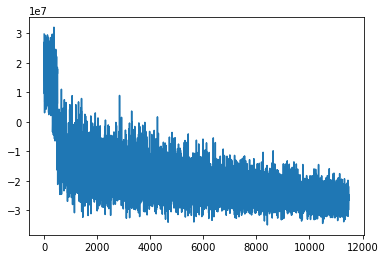

In [60]:
plt.plot(losses[:50000])

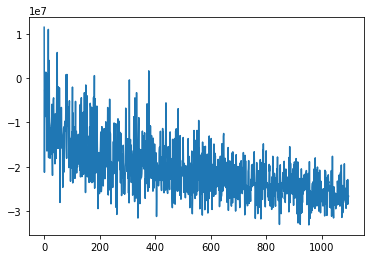

In [61]:
plt.plot(losses[500:50000:10])

/home/lachlan/miniconda3/envs/rbmvae/lib/python3.7/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/lachlan/miniconda3/envs/rbmvae/lib/python3.7/site-packages/torch/nn/functional.py:1794: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/lachlan/miniconda3/envs/rbmvae/lib/python3.7/site-packages/torch/nn/functional.py:4044: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/home/lachlan/miniconda3/envs/rbmvae/lib/python3.7/site-packages/torch/nn/functional.py:3982: UserWarning: Default grid_sample

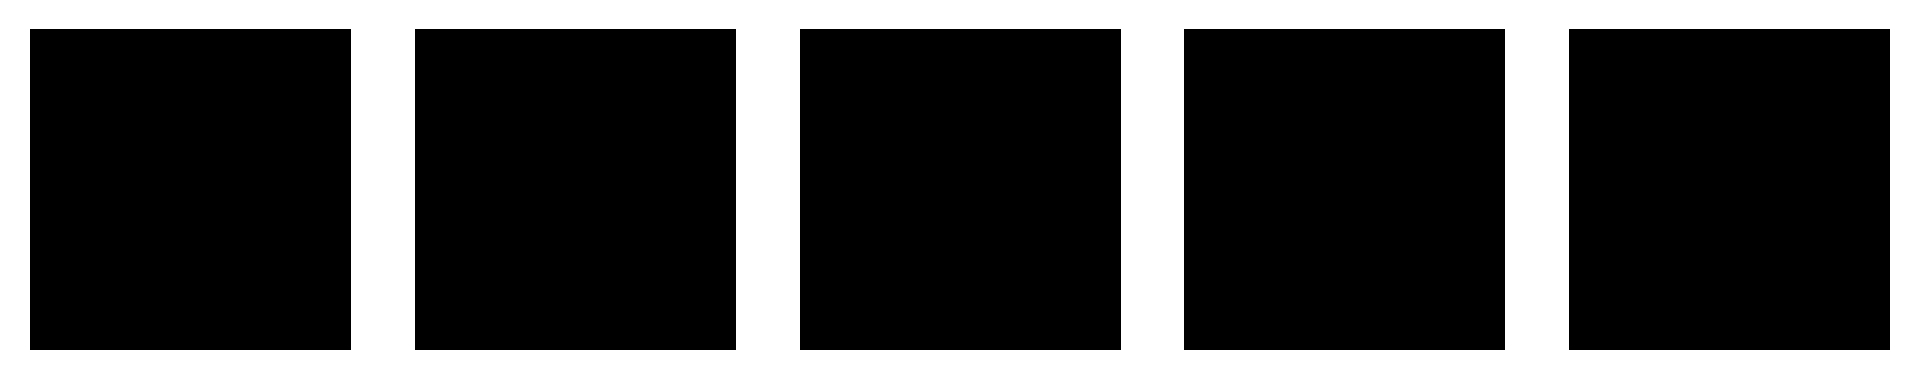

In [62]:
pyro.set_rng_seed(0)
show_images(prior(5)[0].cpu())

In [64]:
start_idx = 10

In [65]:
trace = poutine.trace(guide).get_trace(data[start_idx+0:start_idx+4], y_pres[start_idx+0:start_idx+4])

In [66]:
x, z_where, z_pres = poutine.replay(prior, trace=trace)(data[start_idx+0:start_idx+4].size(0))

In [67]:
# x

In [68]:
z_where

[tensor([[8.5247, 6.3954, 6.4148],
         [8.5292, 8.5265, 8.5220],
         [8.5267, 8.4231, 8.5151],
         [7.9379, 5.9845, 6.6375]], device='cuda:0', grad_fn=<AddBackward0>),
 tensor([[6.8538, 4.5078, 5.3563],
         [8.5137, 5.8308, 8.4775],
         [8.5303, 4.2811, 8.5195],
         [7.4355, 5.3636, 6.2751]], device='cuda:0', grad_fn=<AddBackward0>),
 tensor([[8.5020, 4.2495, 8.2839],
         [8.4625, 3.5788, 8.4557],
         [8.5265, 3.3539, 8.4935],
         [8.5103, 2.9404, 8.4928]], device='cuda:0', grad_fn=<AddBackward0>),
 tensor([[8.2144, 0.3469, 6.1795],
         [8.4985, 2.1211, 8.4941],
         [8.5232, 1.9278, 6.4421],
         [8.5303, 2.1049, 8.3364]], device='cuda:0', grad_fn=<AddBackward0>),
 tensor([[ 8.5205e+00, -7.9740e-03,  6.4155e+00],
         [ 8.5190e+00, -2.3091e-01,  8.4847e+00],
         [ 8.5322e+00, -7.9272e-01,  8.5224e+00],
         [ 8.5268e+00, -1.0035e+00,  8.5217e+00]], device='cuda:0',
        grad_fn=<AddBackward0>),
 tensor([[ 8.5217

In [69]:
z_pres

[tensor([[0.],
         [0.],
         [0.],
         [1.]]),
 tensor([[1.],
         [0.],
         [0.],
         [2.]]),
 tensor([[1.],
         [0.],
         [1.],
         [3.]]),
 tensor([[1.],
         [0.],
         [1.],
         [3.]]),
 tensor([[1.],
         [0.],
         [2.],
         [4.]]),
 tensor([[1.],
         [0.],
         [2.],
         [5.]]),
 tensor([[1.],
         [0.],
         [3.],
         [5.]]),
 tensor([[1.],
         [0.],
         [3.],
         [6.]]),
 tensor([[1.],
         [0.],
         [4.],
         [7.]]),
 tensor([[1.],
         [0.],
         [4.],
         [8.]]),
 tensor([[1.],
         [0.],
         [4.],
         [9.]]),
 tensor([[ 2.],
         [ 0.],
         [ 4.],
         [10.]]),
 tensor([[ 2.],
         [ 0.],
         [ 4.],
         [11.]]),
 tensor([[ 2.],
         [ 0.],
         [ 4.],
         [11.]]),
 tensor([[ 2.],
         [ 0.],
         [ 4.],
         [12.]]),
 tensor([[ 2.],
         [ 0.],
         [ 4.],
      

In [70]:
import matplotlib.pyplot as plt

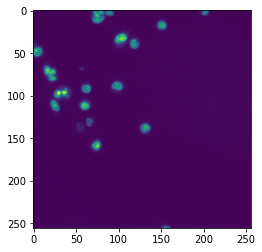

In [71]:
idx = 2
plt.imshow(X_np[idx+start_idx])

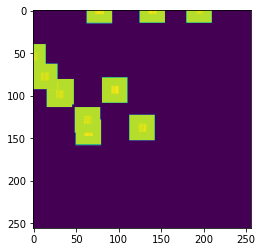

In [72]:
plt.imshow(x[idx].cpu().detach().numpy())

In [73]:
for i in range(2):
    print(i, ": ", x[i].max())
    print(i, ": ", x[i].min())

0 :  tensor(0.4004, device='cuda:0', grad_fn=<MaxBackward1>)
0 :  tensor(0., device='cuda:0', grad_fn=<MinBackward1>)
1 :  tensor(0.4576, device='cuda:0', grad_fn=<MaxBackward1>)
1 :  tensor(0., device='cuda:0', grad_fn=<MinBackward1>)


In [74]:
y_pres[0]

tensor([[0., 1., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 1.]])

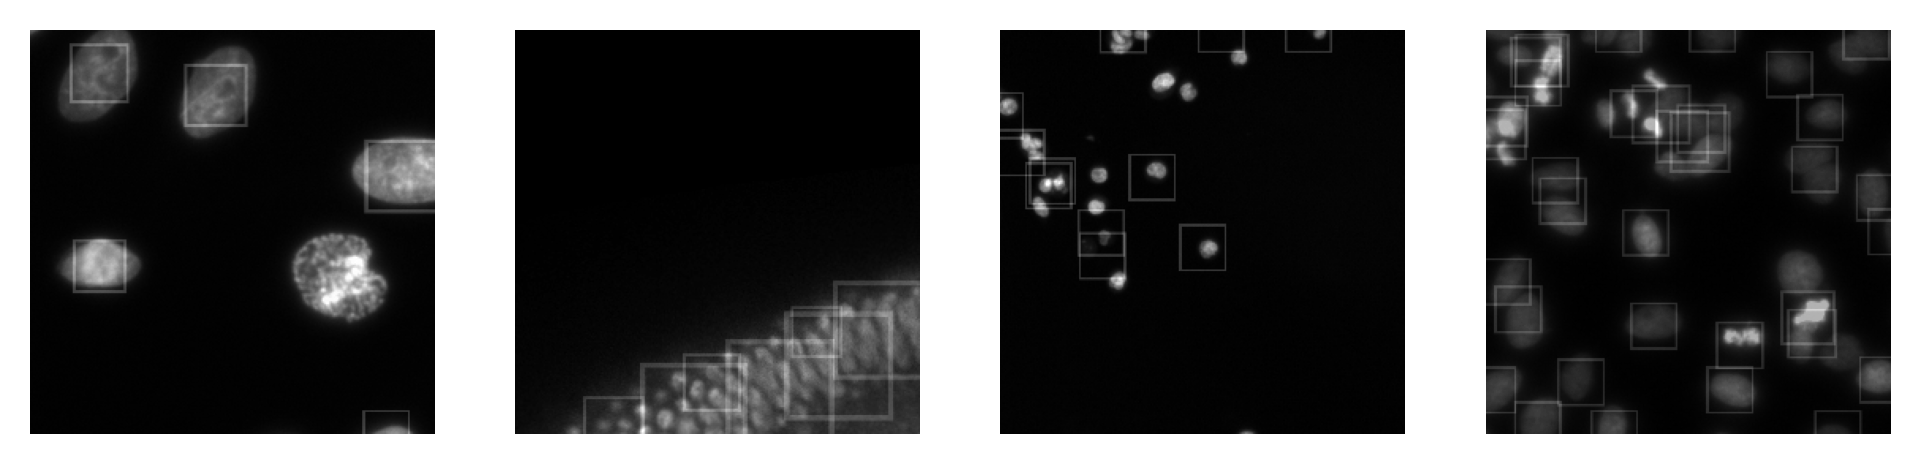

In [75]:
pres = torch.stack(z_pres, axis=0)
where = torch.stack(z_where, axis=0)

def add_square(z_where, obj):
    # print("z_where.shape: ", z_where.shape)
    # print("obj.shape: ", obj.shape)
    
    n = obj.size(0)
    theta = expand_z_where(z_where)
    grid = affine_grid(theta, torch.Size((n, 1,img_height, img_width)))
    out = grid_sample(obj.view(n, 1, obj_height, obj_width), grid)
    return out.view(n, img_height, img_width)

def add_square_all(images, pres, where):
    
    obj = torch.zeros((images.shape[0], 100, 100), device=device)

    obj[:, :5] = 0.2
    obj[:, -5:] = 0.2

    obj[:, :, :5] = 0.2
    obj[:, :, -5:] = 0.2
    
    prev_pres = torch.zeros_like(pres[0], device=device)
    
    for i in range(64):
        images += add_square(where[i], obj) * (pres[i] > prev_pres)[..., None]
        prev_pres = pres[i]
        
    return images

images = add_square_all(torch.from_numpy(X_np[0+start_idx:4+start_idx]).cuda(device=device), pres.cuda(device=device), where)

images.shape

show_images(images.cpu())

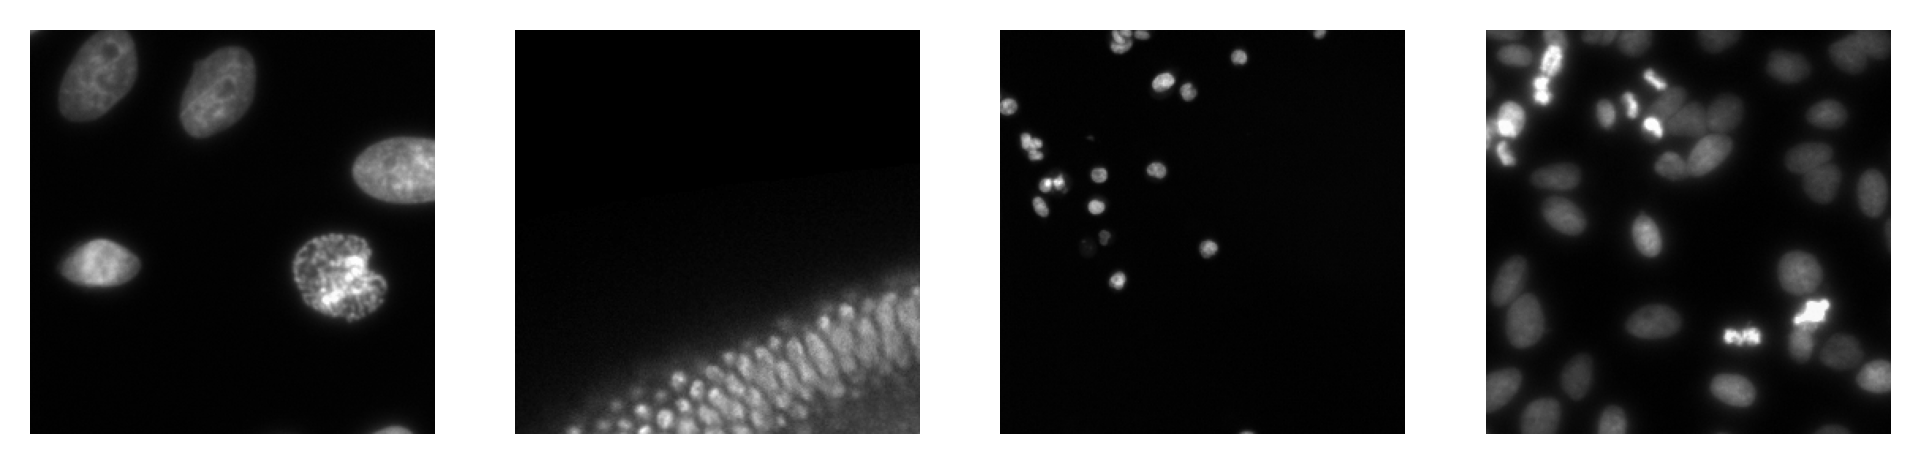

In [76]:
show_images(torch.from_numpy(X_np[0+start_idx:4+start_idx]))